# SPML HW4: Data Poisoning & Backdoor Attacks

It is **strongly recommended** that you read the entire notebook before you start coding as this will help you better understand the tasks and avoid mistakes and redundant implementations.

In [ ]:
######### Make sure to RUN this cell #########
name = 'Alireza Farajtabrizi'
std_id = '403206554'
##############################################

In [ ]:
import copy
import numpy as np
from tqdm import trange, tqdm
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset

from torchvision import transforms
from torchvision.datasets.cifar import CIFAR10
from torchvision.models import resnet18, ResNet18_Weights


torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# CIFAR10 Dataset (5 points)

Load the CIFAR10 dataset.

In [ ]:
# TODO: Load the CIFAR10 dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define DataLoaders for training and testing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


print(f'The trainloader consists of {len(trainloader.dataset)} samples.')
print(f'The testloader consists of {len(testloader.dataset)} samples.')

100%|██████████| 170M/170M [00:18<00:00, 9.12MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
The trainloader consists of 50000 samples.
The testloader consists of 10000 samples.


# Pre-Trained ResNet18 (5 points)

Load the pre-trained resnet18 architecture from torchvision.

In [ ]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.feature_extractor = nn.Sequential(
            *list(resnet18(weights=ResNet18_Weights.DEFAULT).children())[:-2]
            )
        self.fc = nn.Linear(512, 10)

    def get_features(self, x):
        features = self.feature_extractor(x)
        return torch.flatten(features, start_dim=1)

    def forward(self, x):
        logits = self.fc(self.get_features(x))
        return logits

In [ ]:
# TODO: Load the pre-trained model
clean_model = ResNet18()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


# Fine-tuning ResNet18 (5 points)

Train and fine-tune the model on CIFAR10 data.

In [ ]:
def train_model(model, loader, optimizer, criterion, n_epochs=30):
    # TODO: Train the model on the loader for n_epochs
    model.to(device)
    metrics = {"losses": [], "accuracies": []}

    for epoch in trange(n_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(loader)
        epoch_accuracy = 100 * correct / total

        metrics["losses"].append(epoch_loss)
        metrics["accuracies"].append(epoch_accuracy)

        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    return metrics

In [ ]:
# TODO: Define the optimizer, criterion and train the model
criterion = CrossEntropyLoss()

optimizer = Adam(clean_model.parameters(), lr=0.001)

train_model(clean_model, trainloader, optimizer, criterion, 30)

# TODO: Save the model weights for future use
torch.save(clean_model.state_dict(), 'clean_model_weights.pth')

  3%|▎         | 1/30 [00:25<12:31, 25.91s/it]

Epoch 1/30, Loss: 0.9763, Accuracy: 67.2480


  7%|▋         | 2/30 [00:49<11:19, 24.26s/it]

Epoch 2/30, Loss: 0.6721, Accuracy: 77.5640


 10%|█         | 3/30 [01:11<10:38, 23.64s/it]

Epoch 3/30, Loss: 0.5283, Accuracy: 82.0360


 13%|█▎        | 4/30 [01:35<10:13, 23.59s/it]

Epoch 4/30, Loss: 0.4264, Accuracy: 85.6620


 17%|█▋        | 5/30 [01:59<09:51, 23.67s/it]

Epoch 5/30, Loss: 0.3445, Accuracy: 88.2540


 20%|██        | 6/30 [02:22<09:22, 23.46s/it]

Epoch 6/30, Loss: 0.2860, Accuracy: 90.4300


 23%|██▎       | 7/30 [02:45<09:01, 23.53s/it]

Epoch 7/30, Loss: 0.2174, Accuracy: 92.6420


 27%|██▋       | 8/30 [03:11<08:49, 24.06s/it]

Epoch 8/30, Loss: 0.1792, Accuracy: 93.7360


 30%|███       | 9/30 [03:34<08:18, 23.73s/it]

Epoch 9/30, Loss: 0.1641, Accuracy: 94.5120


 33%|███▎      | 10/30 [03:57<07:53, 23.68s/it]

Epoch 10/30, Loss: 0.1187, Accuracy: 95.9600


 37%|███▋      | 11/30 [04:21<07:28, 23.63s/it]

Epoch 11/30, Loss: 0.1051, Accuracy: 96.4960


 40%|████      | 12/30 [04:44<07:05, 23.62s/it]

Epoch 12/30, Loss: 0.1403, Accuracy: 95.3480


 43%|████▎     | 13/30 [05:08<06:39, 23.52s/it]

Epoch 13/30, Loss: 0.1026, Accuracy: 96.5620


 47%|████▋     | 14/30 [05:31<06:15, 23.50s/it]

Epoch 14/30, Loss: 0.0745, Accuracy: 97.4940


 50%|█████     | 15/30 [05:55<05:56, 23.78s/it]

Epoch 15/30, Loss: 0.0744, Accuracy: 97.5800


 53%|█████▎    | 16/30 [06:18<05:28, 23.46s/it]

Epoch 16/30, Loss: 0.0757, Accuracy: 97.4800


 57%|█████▋    | 17/30 [06:42<05:05, 23.54s/it]

Epoch 17/30, Loss: 0.0714, Accuracy: 97.6300


 60%|██████    | 18/30 [07:06<04:44, 23.68s/it]

Epoch 18/30, Loss: 0.0565, Accuracy: 98.0580


 63%|██████▎   | 19/30 [07:29<04:18, 23.52s/it]

Epoch 19/30, Loss: 0.0730, Accuracy: 97.5620


 67%|██████▋   | 20/30 [07:53<03:55, 23.54s/it]

Epoch 20/30, Loss: 0.0512, Accuracy: 98.2400


 70%|███████   | 21/30 [08:17<03:32, 23.65s/it]

Epoch 21/30, Loss: 0.0506, Accuracy: 98.2760


 73%|███████▎  | 22/30 [08:41<03:11, 23.91s/it]

Epoch 22/30, Loss: 0.0710, Accuracy: 97.7040


 77%|███████▋  | 23/30 [09:04<02:45, 23.63s/it]

Epoch 23/30, Loss: 0.0562, Accuracy: 98.1100


 80%|████████  | 24/30 [09:28<02:22, 23.80s/it]

Epoch 24/30, Loss: 0.0413, Accuracy: 98.6340


 83%|████████▎ | 25/30 [09:52<01:58, 23.76s/it]

Epoch 25/30, Loss: 0.0574, Accuracy: 98.0960


 87%|████████▋ | 26/30 [10:15<01:33, 23.47s/it]

Epoch 26/30, Loss: 0.0421, Accuracy: 98.5880


 90%|█████████ | 27/30 [10:39<01:10, 23.65s/it]

Epoch 27/30, Loss: 0.0348, Accuracy: 98.7820


 93%|█████████▎| 28/30 [11:03<00:47, 23.80s/it]

Epoch 28/30, Loss: 0.0461, Accuracy: 98.4540


 97%|█████████▋| 29/30 [11:26<00:23, 23.54s/it]

Epoch 29/30, Loss: 0.0438, Accuracy: 98.5300


100%|██████████| 30/30 [11:50<00:00, 23.67s/it]

Epoch 30/30, Loss: 0.0366, Accuracy: 98.7480


# Testing (5 points)

In [ ]:
clean_model.load_state_dict(torch.load("clean_model_weights.pth", weights_only=True))

<All keys matched successfully>

Report the clean accuracy of the model you trained.

In [ ]:
def test_model(model, loader):
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for testing
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get predictions
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest score

            # Update total and correct counts
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
acc = test_model(clean_model, testloader)
print(f'Clean accuracy on the clean model is {acc:.2f}%')

Clean accuracy on the clean model is 0.79%


# Poisoning Example Generation (20 points)

We want the implement Algorithm 1 from the [Poison Frogs!](https://arxiv.org/abs/1804.00792) paper. The procedure is as follows:


1.   Initialize x: $x_0 \leftarrow b$
2.   Define: $L_p = \| f(x) - f(t) \|^2$
3.   For $i=1$ to `max_iters` do:
  
  3.1. Forward step: $\hat{x}_i = x_{i-1} - \lambda \nabla L_p(x_{i-1})$

  3.2. Backward step: $x_i = \frac{\hat{x}_i + \lambda \beta b}{1 + \beta \lambda}$



In [ ]:
def poisoning_example_generation(model, t, b, lr, beta=0.25, max_iters=1000):
    # TODO: Implement the given algorithm
    x = b.clone()
    criterion = MSELoss()
    for i in range(max_iters):
      model.zero_grad()
      x = x.detach().requires_grad_(True)

      l = criterion(model.get_features(x), model.get_features(t))
      l.backward()

      x = x - lr * x.grad
      x = (x + beta * lr * b) / (1 + beta * lr)
      x = torch.clamp(x, 0, 1)
    return x

Visualize the following sample (*don't change the index*). This is the sample we are going to use as our base.

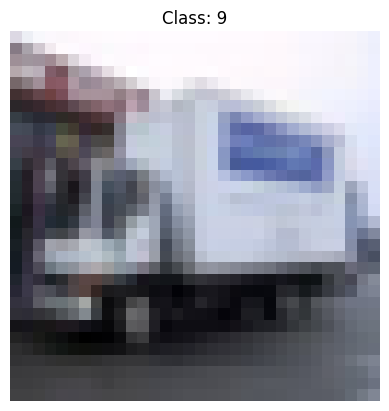

The class of the base image is: 9


In [ ]:
base_image, base_label = testloader.dataset[(int(std_id)-1) % 846]
base_image_np = (base_image).permute(1, 2, 0).numpy()

# Visualize the base image
plt.imshow(base_image_np)
plt.title(f"Class: {base_label}")
plt.axis('off')
plt.show()

# Print the class
print(f"The class of the base image is: {base_label}")

What class does the model think this base image belongs to?
Print the logits and the predicted class.

If the base image is misclassified increment the index until you find an image which is correctly classified (*Now change the index if necessary!*).

In [ ]:
# TODO: Print the output of the model on the base image
logits = clean_model(base_image.unsqueeze(0).to(device))
print("The Model Prediction for Base Image is :", logits.argmax().item())
print("The Model Prediction for Base Image is :", logits.detach().cpu())

The Model Prediction for Base Image is : 9
The Model Prediction for Base Image is : tensor([[-12.5670,   1.2468, -17.9614, -12.9537, -16.4085, -12.5240, -19.6003,
          -4.9216, -15.6374,  22.6744]])


Now choose another image as your target. Visualize this target image and prints its correct label and the models prediction.

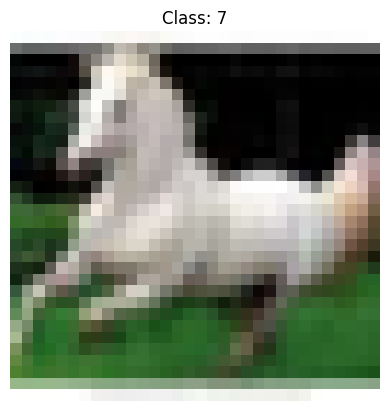

The Class of the Target Image is: 7
The Model Prediction for Target Image is : 7


In [ ]:
# TODO: Select, visualize and show the prediction for the target instance
target_image, target_label = testloader.dataset[(int(std_id)+1) % 846]
target_image_np = (target_image).permute(1, 2, 0).numpy()

# Visualize the base image
plt.imshow(target_image_np)
plt.title(f"Class: {target_label}")
plt.axis('off')
plt.show()

# Print the class
print(f"The Class of the Target Image is: {target_label}")
print("The Model Prediction for Target Image is :",clean_model(target_image.unsqueeze(0).to(device)).argmax().item())

Now use the `poisoning_example_generation` to generate a poison instane using your base and target images. Visualize this poison instance and print the models prediction on it.

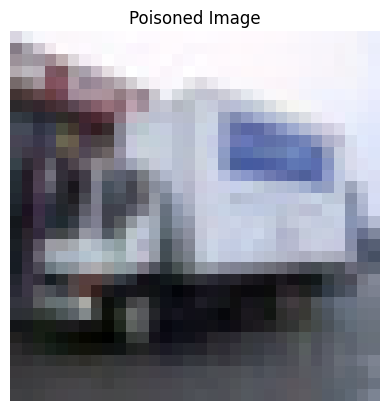

The Target Class for Poison Image is: 7
The Model Prediction for Poisoned Image is : 7


In [ ]:
# TODO: Generate poison instance, visualize it and predict its label
poison = poisoning_example_generation(clean_model, target_image.unsqueeze(0).to(device), base_image.unsqueeze(0).to(device), 0.01)

# Visualize the base image
poison_image_np = (poison.squeeze(0)).permute(1, 2, 0).detach().cpu().numpy()
plt.imshow(poison_image_np)
plt.title(f"Poisoned Image")
plt.axis('off')
plt.show()

# Print the class
print(f"The Target Class for Poison Image is: {target_label}")
print("The Model Prediction for Poisoned Image is :", clean_model(poison.to(device)).argmax().item())


# Poisoned Dataloader (5 points)

Add the poisoned instance to the trainloader and call the resulting loader `poisoned_loader`.

In [ ]:
# TODO: Add poison instance to create the poisoned trainloader
poison_np = np.array(poison.permute(0, 2, 3, 1).detach().cpu()*255, dtype='uint8')
poisonset = CIFAR10(root='./data', train=True, download=True, transform=transform)

poisonset.targets.append(base_label)
poisonset.data = np.append(poisonset.data, poison_np, axis=0)

poisoned_loader = torch.utils.data.DataLoader(poisonset, batch_size=64, shuffle=True, num_workers=2)

print(f'The trainloader consists of {len(trainloader.dataset)} samples.')
print(f'The poisoned trainloader consists of {len(poisoned_loader.dataset)} samples.')

Files already downloaded and verified
The trainloader consists of 50000 samples.
The poisoned trainloader consists of 50001 samples.


# Poisoned Training (5 points)

 Make a copy of your clean model and call it `attacked_model`. Fine-tune the last layer of the `attacked_model` on the `poisoned_loader`.

In [ ]:
# TODO: Fine-tune the last layer of the model using poisoned trainloader
attacked_model = copy.deepcopy(clean_model)

for p in attacked_model.parameters():
    p.requires_grad = False

for p in attacked_model.fc.parameters():
  p.requires_grad = True

optimizer = Adam(attacked_model.parameters(), lr=0.001)
train_model(attacked_model, poisoned_loader, optimizer, criterion, 10)

# TODO: Save the model weights for future use
torch.save(attacked_model.state_dict(), 'attacked_model_transfer_learning_weights.pth')


 10%|█         | 1/10 [00:11<01:47, 11.98s/it]

Epoch 1/10, Loss: 0.0275, Accuracy: 99.0600


 20%|██        | 2/10 [00:23<01:34, 11.85s/it]

Epoch 2/10, Loss: 0.0264, Accuracy: 99.1360


 30%|███       | 3/10 [00:37<01:29, 12.74s/it]

Epoch 3/10, Loss: 0.0255, Accuracy: 99.1400


 40%|████      | 4/10 [00:51<01:18, 13.09s/it]

Epoch 4/10, Loss: 0.0243, Accuracy: 99.2100


 50%|█████     | 5/10 [01:03<01:03, 12.76s/it]

Epoch 5/10, Loss: 0.0242, Accuracy: 99.1360


 60%|██████    | 6/10 [01:14<00:48, 12.10s/it]

Epoch 6/10, Loss: 0.0238, Accuracy: 99.1960


 70%|███████   | 7/10 [01:26<00:36, 12.12s/it]

Epoch 7/10, Loss: 0.0228, Accuracy: 99.2260


 80%|████████  | 8/10 [01:38<00:24, 12.17s/it]

Epoch 8/10, Loss: 0.0226, Accuracy: 99.2300


 90%|█████████ | 9/10 [01:50<00:12, 12.16s/it]

Epoch 9/10, Loss: 0.0230, Accuracy: 99.2660


100%|██████████| 10/10 [02:02<00:00, 12.29s/it]

Epoch 10/10, Loss: 0.0235, Accuracy: 99.2320


Report the clean accuracy of the `attacked_model` on the testloader.

In [ ]:
acc = test_model(attacked_model, testloader)
print(f'Clean accuracy on the attacked model is {acc:.2f}%')

Clean accuracy on the attacked model is 0.81%


Now report the models prediction on the base, target and poison instances.

In [ ]:
# TODO: Predict the label of the base, target, and poison
attacked_model.eval()

with torch.no_grad():
    base_pred = attacked_model(base_image.unsqueeze(0).to(device))
    target_pred = attacked_model(target_image.unsqueeze(0).to(device))
    poison_pred = attacked_model(poison.to(device))

print("Base Sample Label:", base_pred.argmax().item())
print("Target Sample Label:", target_pred.argmax().item())
print("Poison Sample Label:", poison_pred.argmax().item())

Base Sample Label: 9
Target Sample Label: 7
Poison Sample Label: 7


Was the attack successful? Why? What can we do to improve the attack success rate?


`your response:`
##### No it wasn't. Because 1 sample among 50000 doesn't have enough impact on accuracy and loss to drag the model's attention to change its desicion boundry. Another difference in this case compared to paper is the number of classes in the paper there was only 2 classes so it was easier to change the boundry to target.
##### One more thing to pay attention is that since we didnt change the feature extractor the poison sample stayed close to the target and as a result share the prediction.
##### We can make it more successful by adding to the number of poison samples in trainset or using stronger poison samples.

Based on paper TSNE analysis is used when they fine-tuned the whole model (end-to-end) not just the last layer otherwise the TSNE result for clean and attacked model are the same since the feature_extractor is freezed. In this part I did the same as above but with fine-tuning end-to-end.

In [ ]:
# TODO: Fine-tune the whole model using poisoned trainloader
attacked_model = copy.deepcopy(clean_model)

optimizer = Adam(attacked_model.parameters(), lr=0.001)
train_model(attacked_model, poisoned_loader, optimizer, criterion, 10)

# TODO: Save the model weights for future use
torch.save(attacked_model.state_dict(), 'attacked_model_end2end_weights.pth')

 10%|█         | 1/10 [00:24<03:42, 24.75s/it]

Epoch 1/10, Loss: 0.0404, Accuracy: 98.6780


 20%|██        | 2/10 [00:47<03:08, 23.57s/it]

Epoch 2/10, Loss: 0.0419, Accuracy: 98.6120


 30%|███       | 3/10 [01:11<02:45, 23.70s/it]

Epoch 3/10, Loss: 0.0303, Accuracy: 98.9940


 40%|████      | 4/10 [01:36<02:24, 24.09s/it]

Epoch 4/10, Loss: 0.0357, Accuracy: 98.8460


 50%|█████     | 5/10 [01:59<01:58, 23.69s/it]

Epoch 5/10, Loss: 0.0378, Accuracy: 98.7420


 60%|██████    | 6/10 [02:22<01:34, 23.65s/it]

Epoch 6/10, Loss: 0.0295, Accuracy: 99.0240


 70%|███████   | 7/10 [02:46<01:11, 23.73s/it]

Epoch 7/10, Loss: 0.0317, Accuracy: 98.9640


 80%|████████  | 8/10 [03:09<00:47, 23.64s/it]

Epoch 8/10, Loss: 0.0422, Accuracy: 98.7020


 90%|█████████ | 9/10 [03:32<00:23, 23.42s/it]

Epoch 9/10, Loss: 0.0201, Accuracy: 99.3500


100%|██████████| 10/10 [03:57<00:00, 23.74s/it]

Epoch 10/10, Loss: 0.0312, Accuracy: 98.9560


In [ ]:
acc = test_model(attacked_model, testloader)
print(f'Clean accuracy on the attacked model is {acc:.2f}%')

Clean accuracy on the attacked model is 0.80%


In [ ]:
# TODO: Predict the label of the base, target, and poison
attacked_model.eval()

with torch.no_grad():
    base_pred = attacked_model(base_image.unsqueeze(0).to(device))
    target_pred = attacked_model(target_image.unsqueeze(0).to(device))
    poison_pred = attacked_model(poison.to(device))

print("Base Sample Label:", base_pred.argmax().item())
print("Target Sample Label:", target_pred.argmax().item())
print("Poison Sample Label:", poison_pred.argmax().item())

Base Sample Label: 9
Target Sample Label: 7
Poison Sample Label: 9


Was the attack successful? Why? What can we do to improve the attack success rate?


`your response:`
#####No it wasn't. Because as the paper said, when the model is fine-tuned end-to-end, the model will learn to extract other features from poison sample and model will predict it correctly based on true features.
##### Despite the top result here the prediction for poison samples has changed cause the model was also trained on feature extraction layers, therefore the sample features has moved to base class features. we can use more poison samples to drag the model attention to change its behaviour.

# Feature Space Visualization (20 points)

Using `t-SNE` visualize the feature space of the `clean_model` and the `attacked_model` with data from the base and target classes (use different colors for these classes). Visualize the poison instance as well and label it differently (i.e. you can use stars to show poison samples).

***Note: To avoid redundancy, implement this function is such a way that is supports multiple poison samples as opposed to just one!***

In [ ]:
def feature_space_visualizaion(model, loader, poisons, target, base_class, target_class):
    # TODO: Visualize the feature space using t-SNE
    model.eval()
    features = []
    labels = []
    poison_features = []

    # Extract features and labels for base and target class
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            outputs = model.get_features(inputs)

            for i in range(len(outputs)):
                if targets[i] == base_class or targets[i] == target_class:
                    features.append(outputs[i].cpu().numpy())
                    labels.append(targets[i].cpu().numpy())


    # Concatenate all features and labels
    features = np.array(features)
    labels = np.array(labels)

    with torch.no_grad():
        target_feature = model.get_features(target).cpu().numpy()

    # Extract features for poison samples
    poisons = [poison.to(device) for poison in poisons]
    with torch.no_grad():
        for poison in poisons:
            poison_feature = model.get_features(poison.unsqueeze(0))
            poison_features.append(poison_feature.cpu().numpy())

    poison_features = np.concatenate(poison_features, axis=0)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(np.vstack([features, poison_features, target_feature]))

    # Split the transformed features
    features_transformed = features_2d[:features.shape[0]]
    poison_features_transformed = features_2d[features.shape[0]:-1]
    target_feature_transformed = features_2d[-1:]

    # Plotting
    plt.figure(figsize=(10, 8))

    # Plot base class
    base_class_indices = labels == base_class
    plt.scatter(features_transformed[base_class_indices, 0],
                features_transformed[base_class_indices, 1],
                label='Base Class', alpha=0.6)

    # Plot target class
    target_class_indices = labels == target_class
    plt.scatter(features_transformed[target_class_indices, 0],
                features_transformed[target_class_indices, 1],
                label='Target Class', alpha=0.6)

    # Plot poison samples
    plt.scatter(poison_features_transformed[:, 0],
                poison_features_transformed[:, 1],
                marker='*', color='red', s=150, label='Poison Samples')

    # Plot target samples
    plt.scatter(target_feature_transformed[:, 0],
                target_feature_transformed[:, 1],
                marker='s', color='green', s=75, label='Target Sample')

    # Finalize plot
    plt.title('t-SNE Visualization of Feature Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

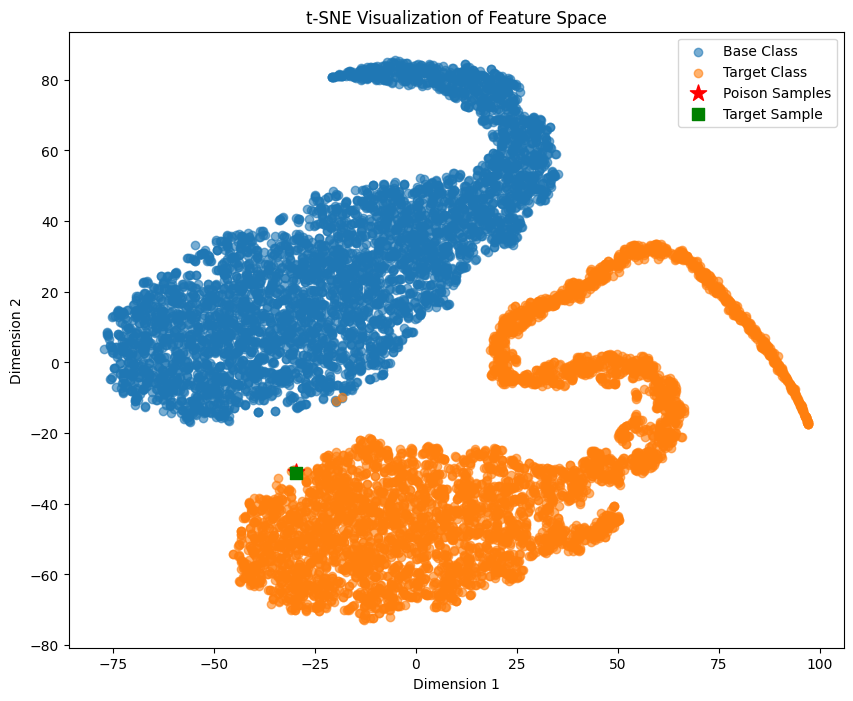

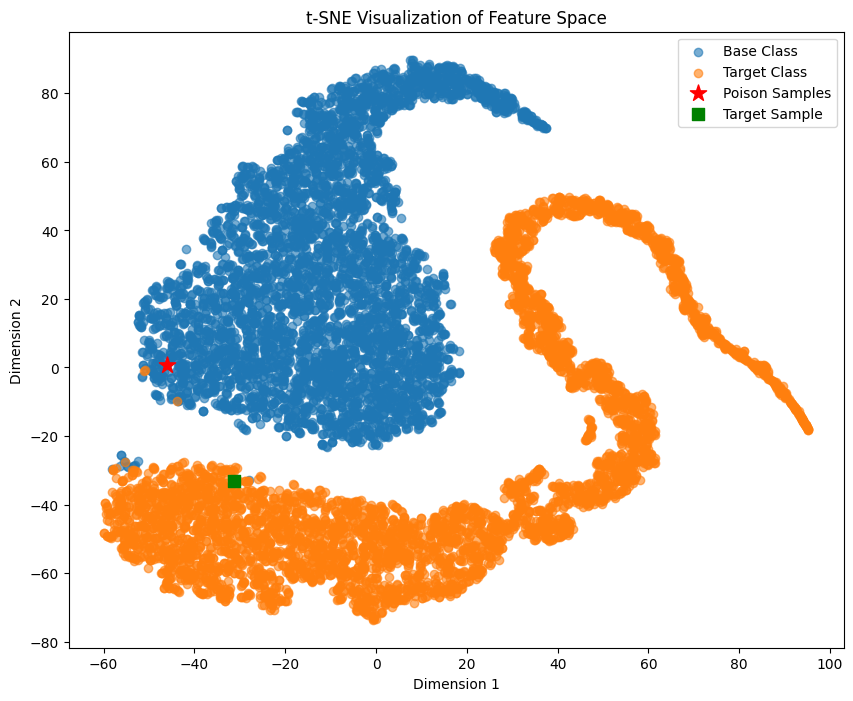

In [ ]:
# TODO: Visualize the clean model
feature_space_visualizaion(clean_model, trainloader, poison, target_image.unsqueeze(0).to(device), base_label, target_label)

# TODO: Visualize the attacked model
feature_space_visualizaion(attacked_model, trainloader, poison, target_image.unsqueeze(0).to(device), base_label, target_label)

What do you see? What did you expect? Why?

`your response:`
##### I see that in clean model's feature space the poison sample and target sample are close.
##### After training an attack model end-to-end the model learns to separate these two from each other.
##### I kinda expect the same since model has high number of parameters and the poison sample is close to base class in input space so it was predictable that the model will learn to classify it without misclassifying the target.

# Watermark Poisoning (10 points)

A base watermarked image with target opacity $\gamma$ is formed by taking a weighted combination of the base and the target images.
$$t: b \leftarrow \gamma \cdot t + (1 - \gamma ) \cdot b$$

We use this method to boost the power of poison attacks.

In [ ]:
def poisoning_watermark_generation(t, b, gamma=0.3):
    # TODO: Perform watermarking
    watermarked_image = (1 - gamma) * b + gamma * t
    watermarked_image = np.clip(watermarked_image, 0, 255)

    return watermarked_image.astype(np.uint8)

def visualize_samples(samples, rows=10, cols=10):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    for i, ax in enumerate(axes.flat):
        if i < len(samples):
            ax.imshow(samples[i])
            ax.axis('off')
    plt.tight_layout()
    plt.show()

Generate 100 poisons by adding a low opacity watermark of the target instance to the base and visualize the results. (*samples must be from the same class*)

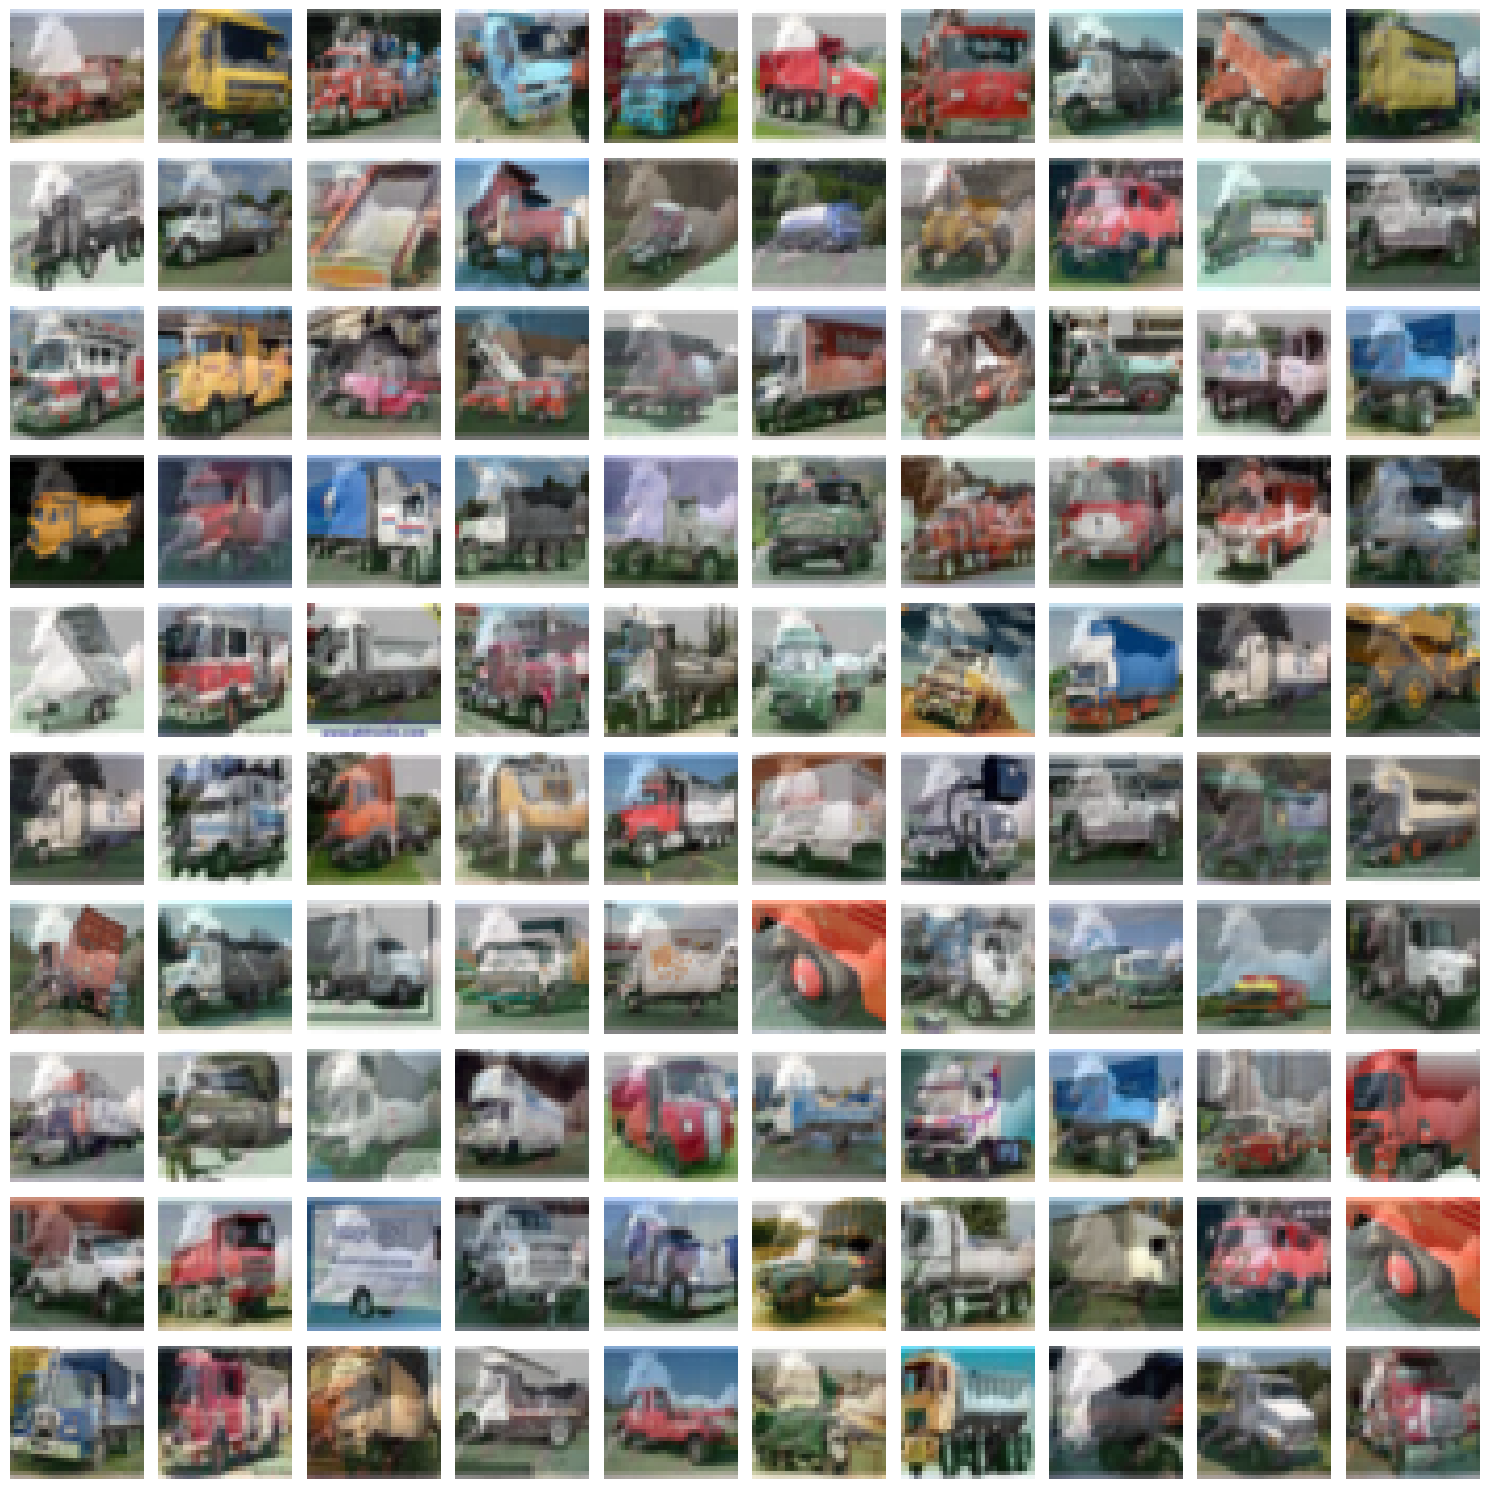

In [ ]:
# TODO: Generate 100 poison samples and visualize the results
watermark_count = 100
base_class = []
poisons = []

for i in range(len(testset.targets)):
  if testset.targets[i] == base_label:
    base_class.append(testset.data[i])

np.random.seed(42)
samples_index = np.random.randint(0, len(base_class), watermark_count)
for i in samples_index:
    poisons.append(poisoning_watermark_generation(target_image_np*255, base_class[i]))

visualize_samples(poisons)

# Watermark Dataloader (5 points)

Add the watermark instances to the trainloader and call the resulting loader `watermark_loader`.

In [ ]:
# TODO: Add watermark instances to create the watermark trainloader
watermarkset = CIFAR10(root='./data', train=True, download=True, transform=transform)

for i in range(len(poisons)):
  watermarkset.targets.append(base_label)
  watermarkset.data = np.append(watermarkset.data, np.expand_dims(poisons[i], axis=0) , axis=0)

watermark_loader = torch.utils.data.DataLoader(watermarkset, batch_size=64, shuffle=True, num_workers=2)

print(f'The trainloader consists of {len(trainloader.dataset)} samples.')
print(f'The poisoned trainloader consists of {len(poisoned_loader.dataset)} samples.')
print(f'The watermark loader consists of {len(watermark_loader.dataset)} samples.')

Files already downloaded and verified
The trainloader consists of 50000 samples.
The poisoned trainloader consists of 50001 samples.
The watermark loader consists of 50100 samples.


# Watermark Training (5 points)

Repeat the training steps and report the clean accuracy on the newly trained model. Use another copy of the `clean_model` and train the new network on the `watermark_loader` and report the clean accuracy on this model.

In [ ]:
# TODO: Repeat training steps for the new model
wattermarked_model = copy.deepcopy(clean_model)

optimizer = Adam(wattermarked_model.parameters(), lr=0.001)
train_model(wattermarked_model, watermark_loader, optimizer, criterion, 10)

# TODO: Save the model weights for future use
torch.save(wattermarked_model.state_dict(), 'wattermarked_model_weights.pth')

 10%|█         | 1/10 [00:23<03:27, 23.03s/it]

Epoch 1/10, Loss: 0.0441, Accuracy: 98.6347


 20%|██        | 2/10 [00:47<03:09, 23.65s/it]

Epoch 2/10, Loss: 0.0319, Accuracy: 98.8503


 30%|███       | 3/10 [01:10<02:45, 23.68s/it]

Epoch 3/10, Loss: 0.0356, Accuracy: 98.8204


 40%|████      | 4/10 [01:34<02:22, 23.75s/it]

Epoch 4/10, Loss: 0.0324, Accuracy: 98.8962


 50%|█████     | 5/10 [02:00<02:01, 24.32s/it]

Epoch 5/10, Loss: 0.0321, Accuracy: 98.9581


 60%|██████    | 6/10 [02:27<01:41, 25.42s/it]

Epoch 6/10, Loss: 0.0425, Accuracy: 98.6567


 70%|███████   | 7/10 [02:51<01:15, 25.06s/it]

Epoch 7/10, Loss: 0.0334, Accuracy: 98.9461


 80%|████████  | 8/10 [03:15<00:49, 24.51s/it]

Epoch 8/10, Loss: 0.0381, Accuracy: 98.7265


 90%|█████████ | 9/10 [03:39<00:24, 24.33s/it]

Epoch 9/10, Loss: 0.0252, Accuracy: 99.1637


100%|██████████| 10/10 [04:03<00:00, 24.32s/it]

Epoch 10/10, Loss: 0.0253, Accuracy: 99.1597


In [ ]:
acc = test_model(wattermarked_model, testloader)
print(f'Clean accuracy on the attacked model is {acc:.2f}%')

Clean accuracy on the attacked model is 0.79%


# Watermarking Results (10 points)

Now check if the poisoning attack is successful.

In [ ]:
# TODO: Evaluate the attack
wattermarked_model.eval()
watermark_pred = 0

with torch.no_grad():
    base_pred = wattermarked_model(base_image.unsqueeze(0).to(device))
    target_pred = wattermarked_model(target_image.unsqueeze(0).to(device))
    for i in range(watermark_count):
        watermark_pred += wattermarked_model(watermarkset[-i-1][0].unsqueeze(0).to(device)).argmax().item() == base_label

print("Base Sample Label:", base_pred.argmax().item())
print("Target Sample Label:", target_pred.argmax().item())
print("Watermark Samples Label = Base label Percentage:", watermark_pred/watermark_count)

Base Sample Label: 9
Target Sample Label: 7
Watermark Samples Label = Base label Percentage: 1.0


Using the `feature_space_visualizaion` function you wrote earlier (modify it if necessary) visualize the feature space for this model as well.

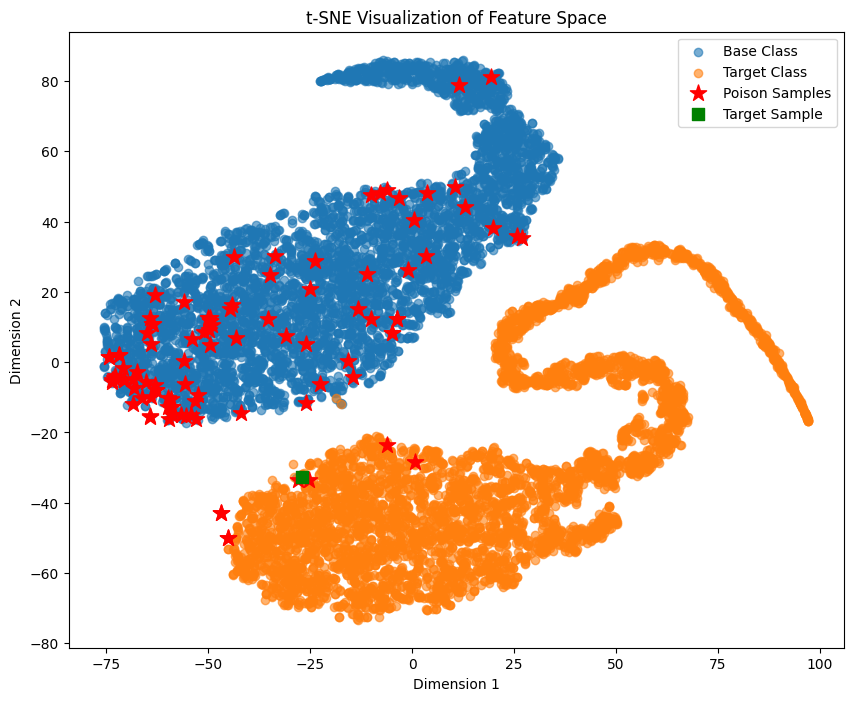

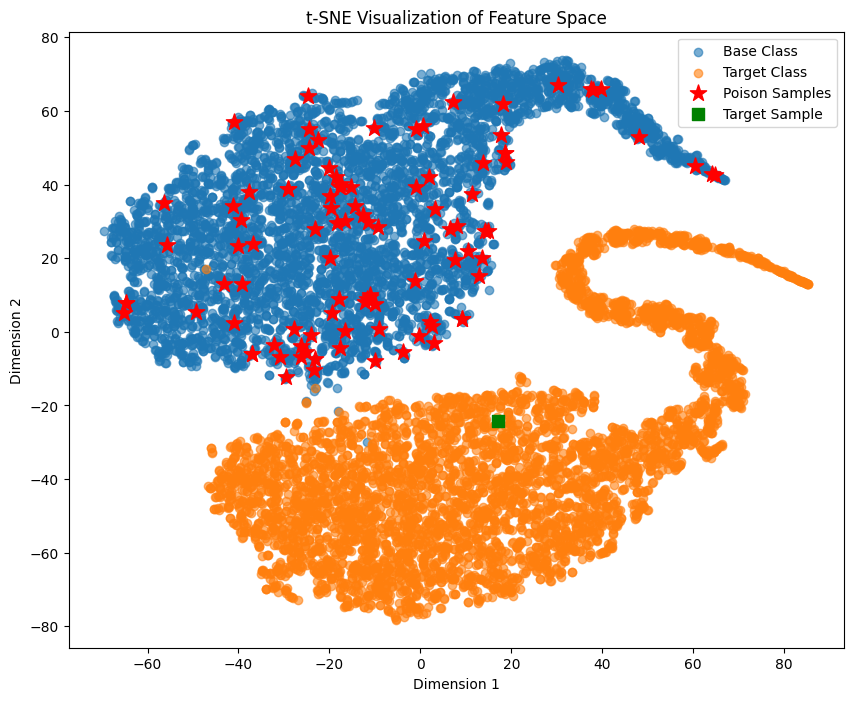

In [ ]:
# Visualize the clean model
watermarks = [watermarkset[-i-1][0] for i in range(watermark_count)]
feature_space_visualizaion(clean_model, trainloader, watermarks, target_image.unsqueeze(0).to(device), base_label, target_label)

# Visualize the attacked model
watermarks = [watermarkset[-i-1][0] for i in range(watermark_count)]
feature_space_visualizaion(wattermarked_model, trainloader, watermarks, target_image.unsqueeze(0).to(device), base_label, target_label)

Summarize your findings.


`your response:`
##### As you can see the model still doesnt classify the target to base class which can have many reasons:
##### The poison samples should be even more than 100 or stronger(which I will try in following cells) or the chance of the target and base class are not good for this task... .

##### The first TSNE in above shows that the watermarking is not mixing the features well enough and the samples fall in base class feature space.
##### My overall findings is that when we are doing end to end training we need more samples and stronger poisons to drag the models attention to target sample otherwise it wont change the class of it. The posioning task is not and easy one like adversarial example generation and its more sensitive to  hyperparamters.

## Fine-tuning last layer with only Watermark Samples:

In [ ]:
# model defenition and train
wattermarked_model = copy.deepcopy(clean_model)

for p in wattermarked_model.parameters():
    p.requires_grad = False

for p in wattermarked_model.fc.parameters():
  p.requires_grad = True

optimizer = Adam(wattermarked_model.parameters(), lr=0.001)
train_model(wattermarked_model, watermark_loader, optimizer, criterion, 10)

# model testing
acc = test_model(wattermarked_model, testloader)
print(f'Clean accuracy on the attacked model is {acc:.2f}%')

# Evaluate the attack
wattermarked_model.eval()
watermark_pred = 0
with torch.no_grad():
    base_pred = wattermarked_model(base_image.unsqueeze(0).to(device))
    target_pred = wattermarked_model(target_image.unsqueeze(0).to(device))
    for i in range(watermark_count):
        watermark_pred += wattermarked_model(watermarkset[-i-1][0].unsqueeze(0).to(device)).argmax().item() == base_label

print("Base Sample Label:", base_pred.argmax().item())
print("Target Sample Label:", target_pred.argmax().item())
print("Watermark Samples Label = Base label Percentage:", watermark_pred/watermark_count)

 10%|█         | 1/10 [00:12<01:49, 12.12s/it]

Epoch 1/10, Loss: 0.0301, Accuracy: 98.9780


 20%|██        | 2/10 [00:24<01:35, 11.99s/it]

Epoch 2/10, Loss: 0.0271, Accuracy: 99.1198


 30%|███       | 3/10 [00:35<01:21, 11.59s/it]

Epoch 3/10, Loss: 0.0262, Accuracy: 99.1317


 40%|████      | 4/10 [00:47<01:10, 11.78s/it]

Epoch 4/10, Loss: 0.0264, Accuracy: 99.1297


 50%|█████     | 5/10 [00:59<01:00, 12.01s/it]

Epoch 5/10, Loss: 0.0262, Accuracy: 99.1657


 60%|██████    | 6/10 [01:11<00:48, 12.09s/it]

Epoch 6/10, Loss: 0.0266, Accuracy: 99.1158


 70%|███████   | 7/10 [01:24<00:36, 12.18s/it]

Epoch 7/10, Loss: 0.0251, Accuracy: 99.1257


 80%|████████  | 8/10 [01:38<00:25, 12.72s/it]

Epoch 8/10, Loss: 0.0257, Accuracy: 99.2116


 90%|█████████ | 9/10 [01:49<00:12, 12.17s/it]

Epoch 9/10, Loss: 0.0259, Accuracy: 99.1257


100%|██████████| 10/10 [02:00<00:00, 12.10s/it]

Epoch 10/10, Loss: 0.0258, Accuracy: 99.1118


Clean accuracy on the attacked model is 0.81%
Base Sample Label: 9
Target Sample Label: 7
Watermark Samples Label = Base label Percentage: 0.81


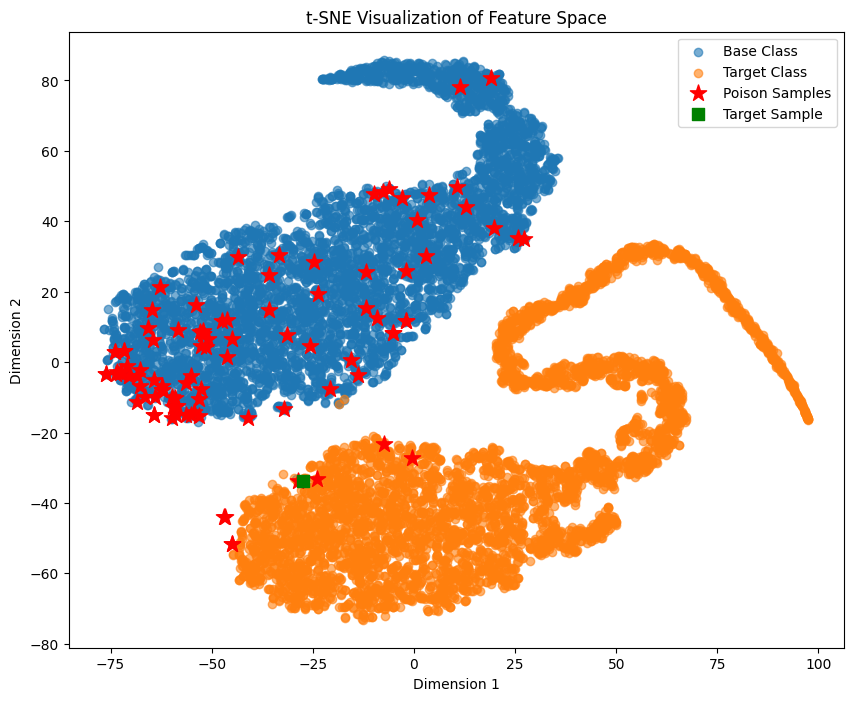

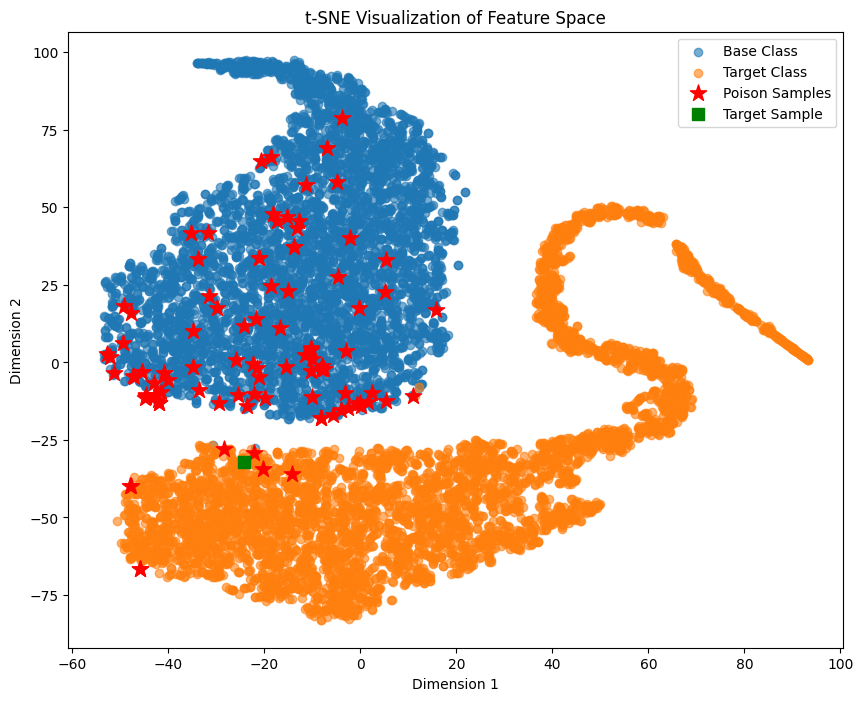

In [ ]:
# Visualize the clearn model
watermarks = [watermarkset[-i-1][0] for i in range(watermark_count)]
feature_space_visualizaion(clean_model, trainloader, watermarks, target_image.unsqueeze(0).to(device), base_label, target_label)

# Visualize the attacked model
watermarks = [watermarkset[-i-1][0] for i in range(watermark_count)]
feature_space_visualizaion(wattermarked_model, trainloader, watermarks, target_image.unsqueeze(0).to(device), base_label, target_label)

## Try More Watermarked Samples (400)




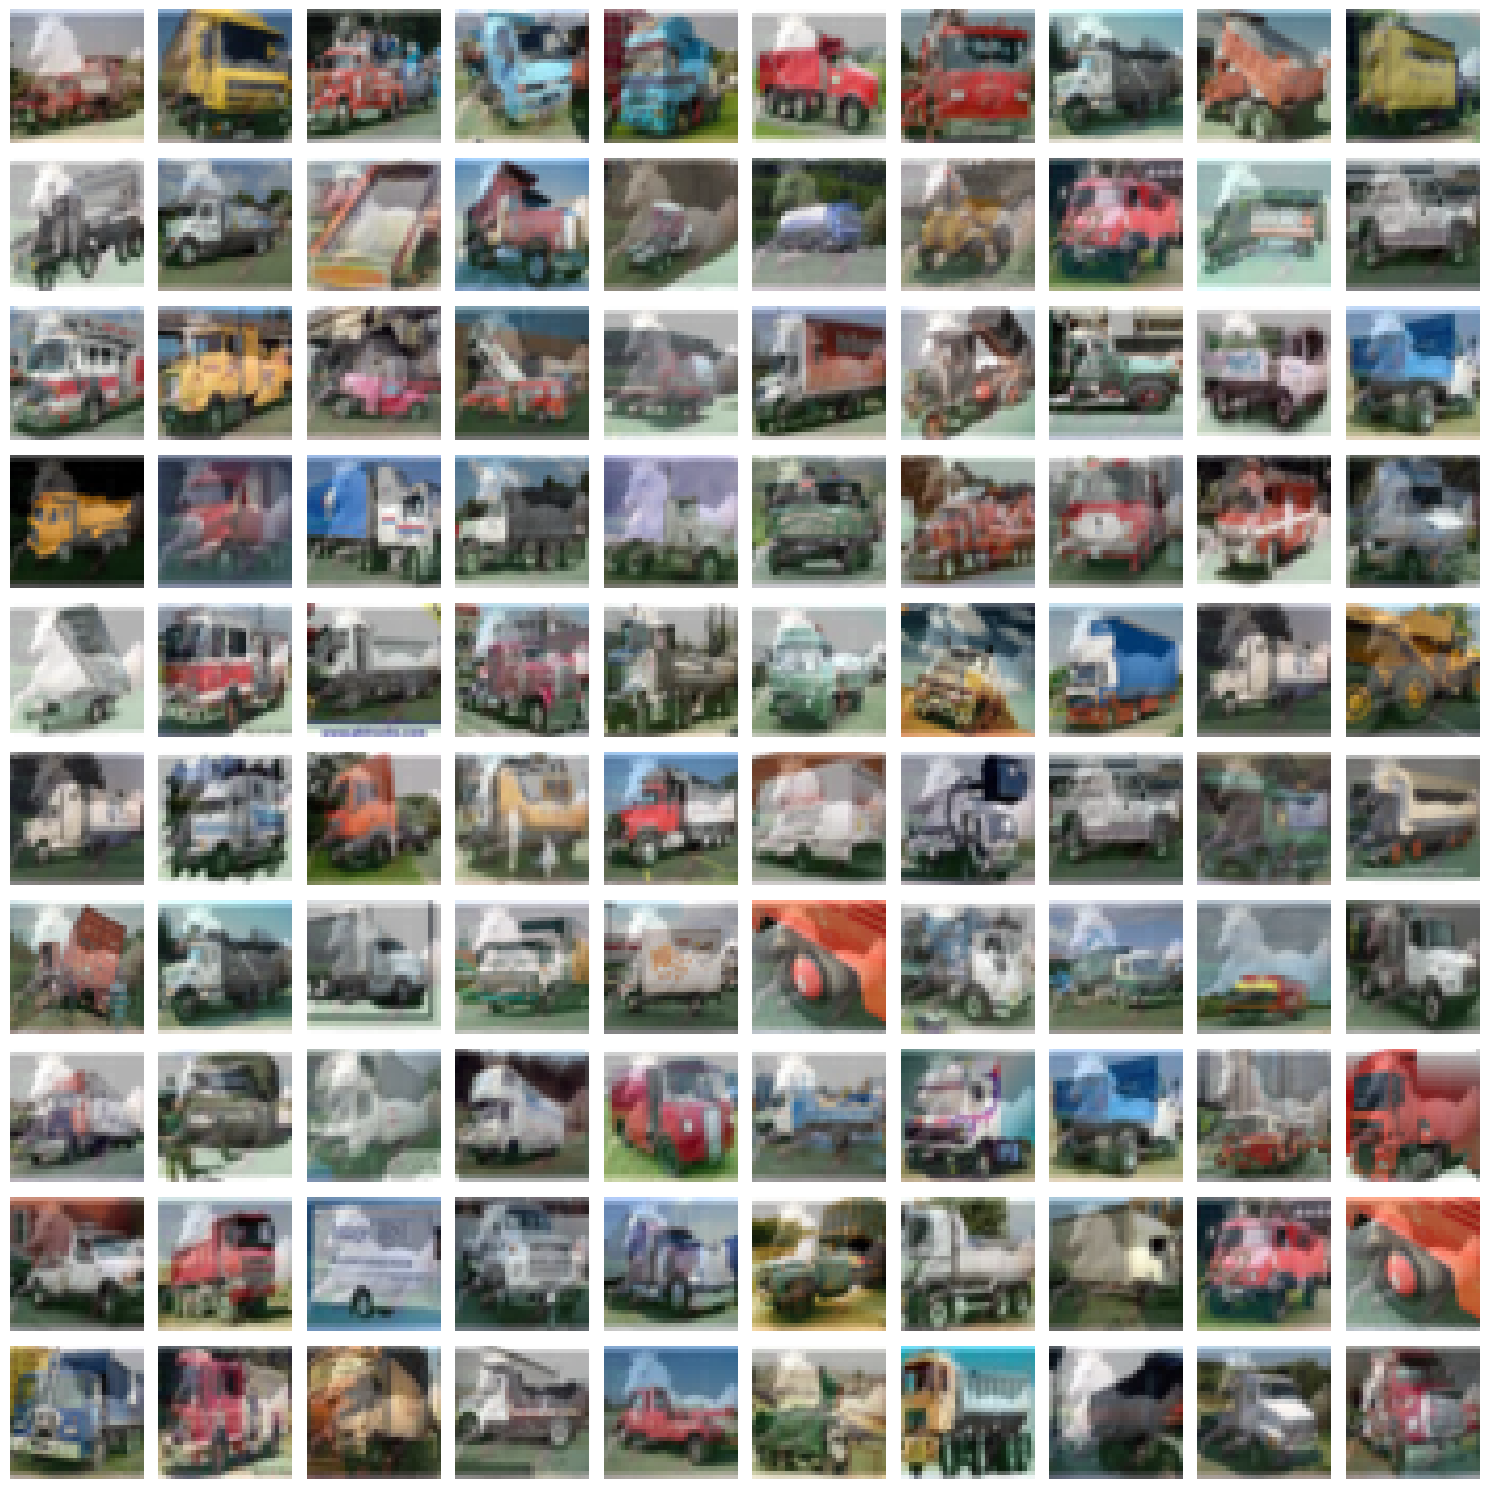

Files already downloaded and verified
The watermark loader consists of 50500 samples.


 10%|█         | 1/10 [00:23<03:34, 23.87s/it]

Epoch 1/10, Loss: 0.0508, Accuracy: 98.2733


 20%|██        | 2/10 [00:48<03:12, 24.07s/it]

Epoch 2/10, Loss: 0.0723, Accuracy: 97.8455


 30%|███       | 3/10 [01:11<02:47, 23.90s/it]

Epoch 3/10, Loss: 0.0178, Accuracy: 99.4554


 40%|████      | 4/10 [01:35<02:23, 23.95s/it]

Epoch 4/10, Loss: 0.0454, Accuracy: 98.5307


 50%|█████     | 5/10 [01:59<01:59, 23.92s/it]

Epoch 5/10, Loss: 0.0610, Accuracy: 98.7168


 60%|██████    | 6/10 [02:22<01:34, 23.61s/it]

Epoch 6/10, Loss: 0.0955, Accuracy: 97.1149


 70%|███████   | 7/10 [02:46<01:11, 23.80s/it]

Epoch 7/10, Loss: 0.0276, Accuracy: 99.3604


 80%|████████  | 8/10 [03:11<00:48, 24.11s/it]

Epoch 8/10, Loss: 0.0418, Accuracy: 98.7109


 90%|█████████ | 9/10 [03:35<00:24, 24.09s/it]

Epoch 9/10, Loss: 0.0418, Accuracy: 98.7842


100%|██████████| 10/10 [03:58<00:00, 23.90s/it]

Epoch 10/10, Loss: 0.0678, Accuracy: 97.9703


Clean accuracy on the attacked model is 0.80%
Base Sample Label: 9
Target Sample Label: 9
Watermark Samples Label = Base label Percentage: 1.0


In [ ]:
# define new large watermarkset
watermark_count = 500
base_class = []
poisons = []

for i in range(len(testset.targets)):
  if testset.targets[i] == base_label:
    base_class.append(testset.data[i])

np.random.seed(42)
samples_index = np.random.randint(0, len(base_class), watermark_count)
for i in samples_index:
    poisons.append(poisoning_watermark_generation(target_image_np*255, base_class[i]))

visualize_samples(poisons)
watermarkset = CIFAR10(root='./data', train=True, download=True, transform=transform)

for i in range(len(poisons)):
  watermarkset.targets.append(base_label)
  watermarkset.data = np.append(watermarkset.data, np.expand_dims(poisons[i], axis=0) , axis=0)

watermark_loader = torch.utils.data.DataLoader(watermarkset, batch_size=64, shuffle=True, num_workers=2)

print(f'The watermark loader consists of {len(watermark_loader.dataset)} samples.')

# model defenition and train
wattermarked_model = copy.deepcopy(clean_model)

optimizer = Adam(wattermarked_model.parameters(), lr=0.001)
train_model(wattermarked_model, watermark_loader, optimizer, criterion, 10)

# model testing
acc = test_model(wattermarked_model, testloader)
print(f'Clean accuracy on the attacked model is {acc:.2f}%')

# Evaluate the attack
wattermarked_model.eval()
watermark_pred = 0
with torch.no_grad():
    base_pred = wattermarked_model(base_image.unsqueeze(0).to(device))
    target_pred = wattermarked_model(target_image.unsqueeze(0).to(device))
    for i in range(watermark_count):
        watermark_pred += wattermarked_model(watermarkset[-i-1][0].unsqueeze(0).to(device)).argmax().item() == base_label

print("Base Sample Label:", base_pred.argmax().item())
print("Target Sample Label:", target_pred.argmax().item())
print("Watermark Samples Label = Base label Percentage:", watermark_pred/watermark_count)

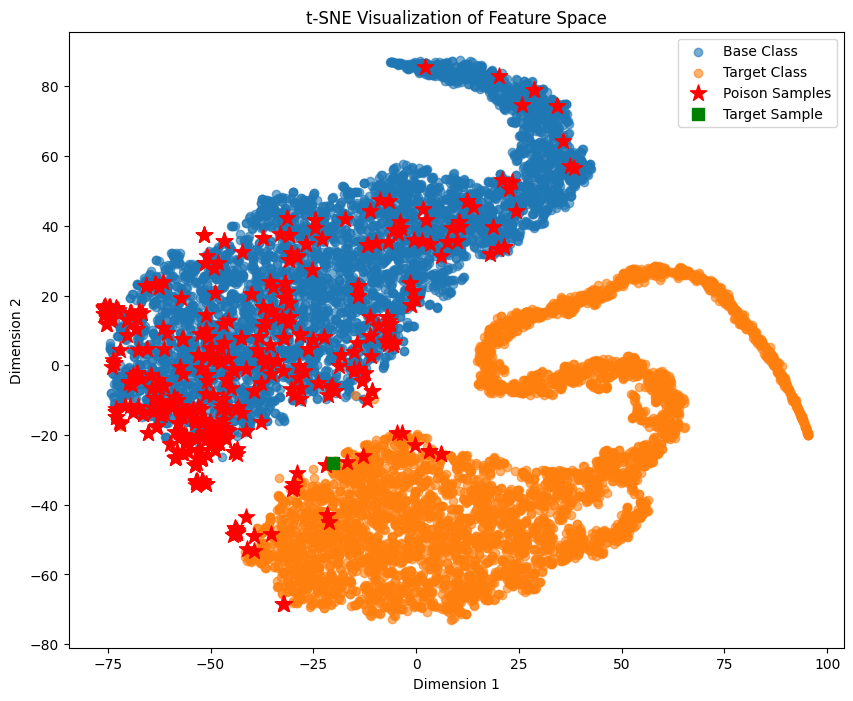

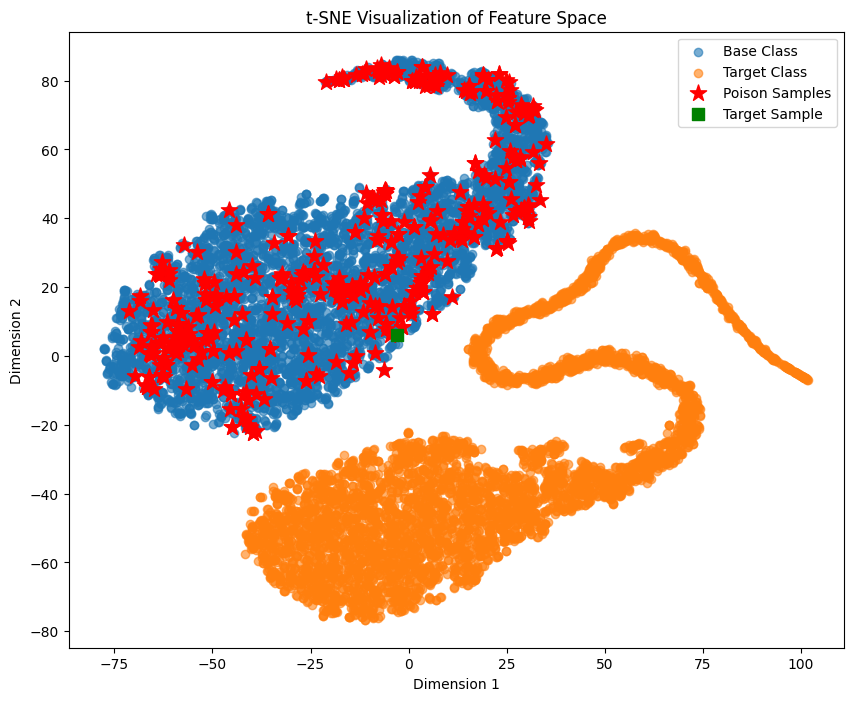

In [ ]:
# Visualize the clearn model
watermarks = [watermarkset[-i-1][0] for i in range(watermark_count)]
feature_space_visualizaion(clean_model, trainloader, watermarks, target_image.unsqueeze(0).to(device), base_label, target_label)

# Visualize the attacked model
watermarks = [watermarkset[-i-1][0] for i in range(watermark_count)]
feature_space_visualizaion(wattermarked_model, trainloader, watermarks, target_image.unsqueeze(0).to(device), base_label, target_label)

## Try Stronger Watermarked Samples (Gamma = 0.5! )

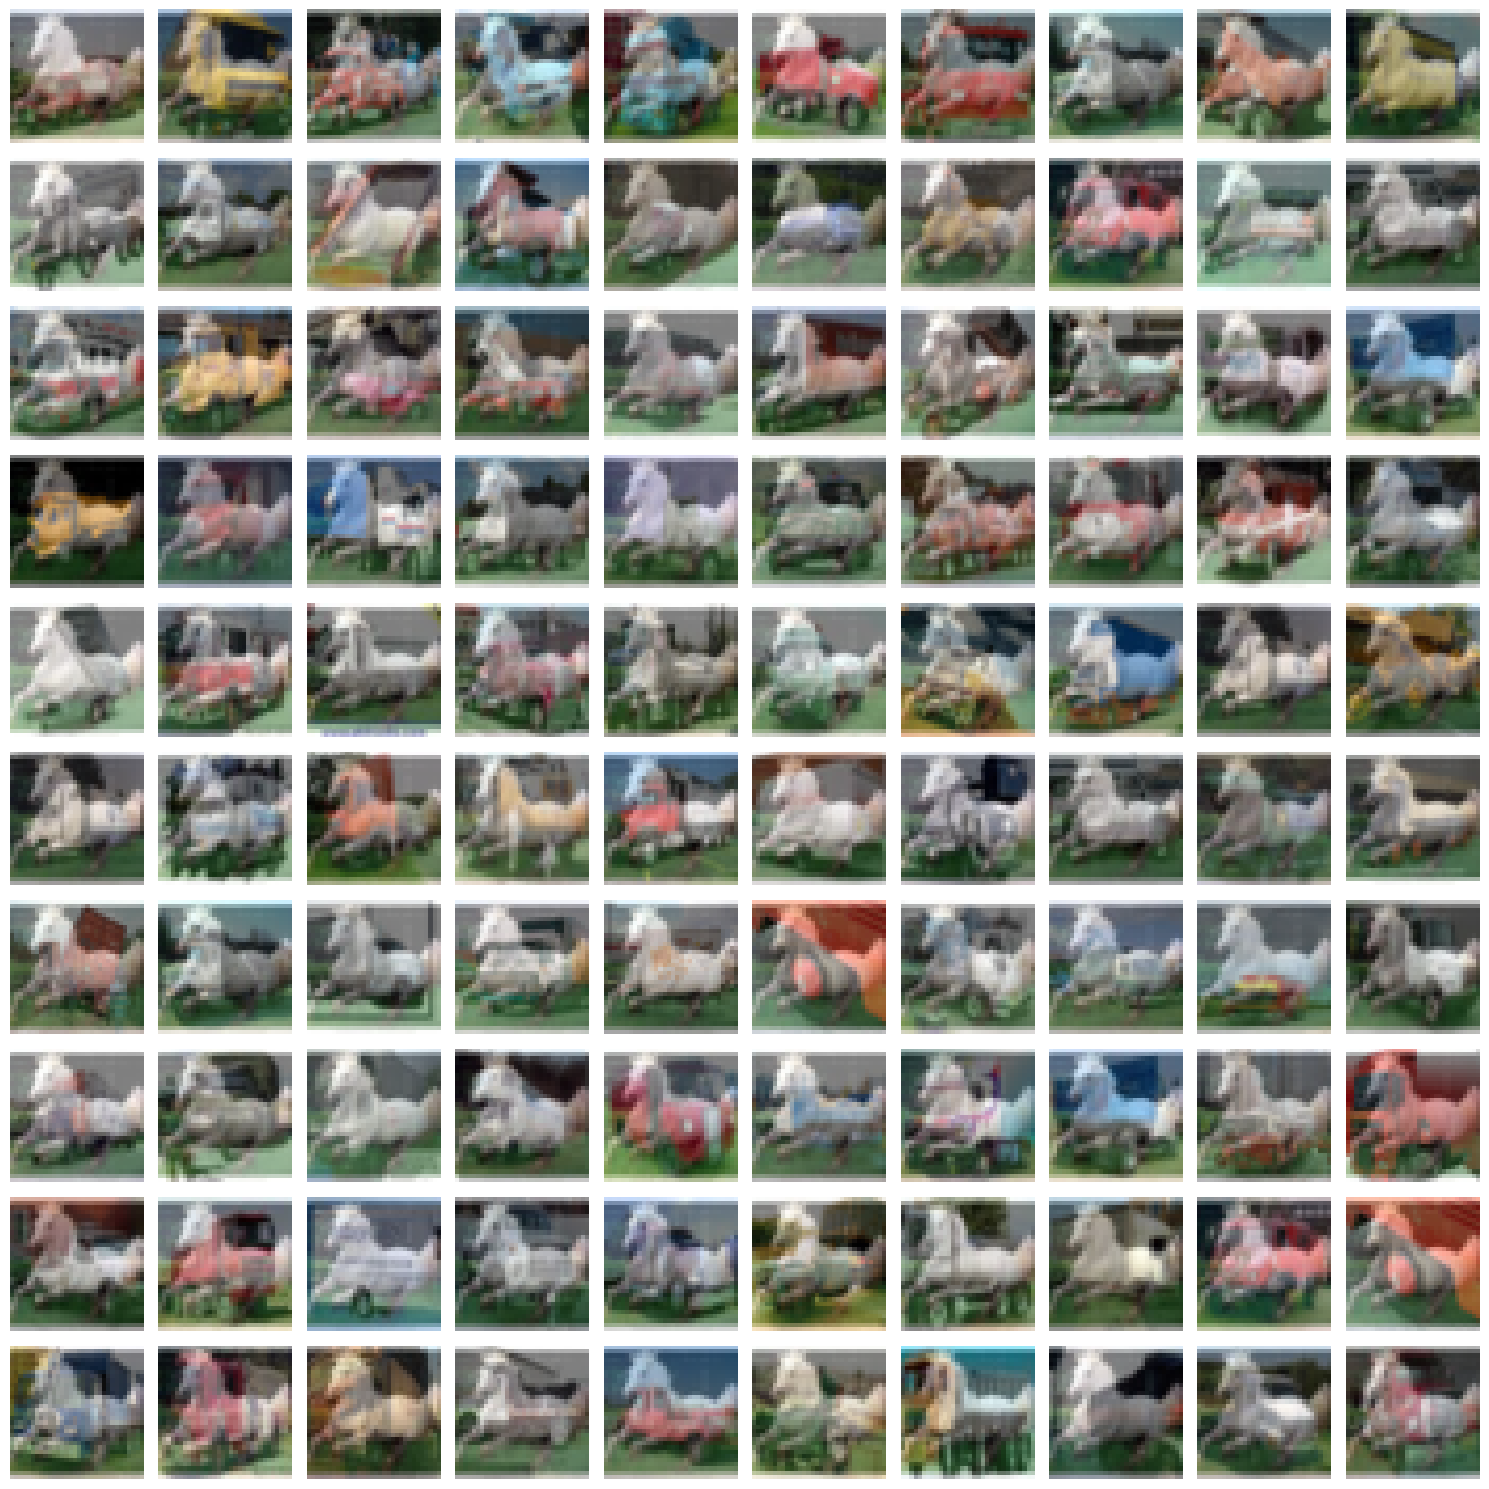

Files already downloaded and verified
The watermark loader consists of 50100 samples.


 10%|█         | 1/10 [00:24<03:42, 24.67s/it]

Epoch 1/10, Loss: 0.0415, Accuracy: 98.5868


 20%|██        | 2/10 [00:47<03:08, 23.58s/it]

Epoch 2/10, Loss: 0.0567, Accuracy: 98.2056


 30%|███       | 3/10 [01:11<02:46, 23.79s/it]

Epoch 3/10, Loss: 0.0301, Accuracy: 99.0559


 40%|████      | 4/10 [01:35<02:22, 23.76s/it]

Epoch 4/10, Loss: 0.0365, Accuracy: 98.7545


 50%|█████     | 5/10 [01:58<01:58, 23.68s/it]

Epoch 5/10, Loss: 0.0287, Accuracy: 99.0419


 60%|██████    | 6/10 [02:22<01:34, 23.60s/it]

Epoch 6/10, Loss: 0.0317, Accuracy: 98.9501


 70%|███████   | 7/10 [02:47<01:12, 24.01s/it]

Epoch 7/10, Loss: 0.0320, Accuracy: 98.9521


 80%|████████  | 8/10 [03:10<00:47, 23.89s/it]

Epoch 8/10, Loss: 0.0273, Accuracy: 99.0938


 90%|█████████ | 9/10 [03:33<00:23, 23.67s/it]

Epoch 9/10, Loss: 0.0311, Accuracy: 98.9880


100%|██████████| 10/10 [03:57<00:00, 23.73s/it]

Epoch 10/10, Loss: 0.0271, Accuracy: 99.0639


Clean accuracy on the attacked model is 0.80%
Base Sample Label: 9
Target Sample Label: 9
Watermark Samples Label = Base label Percentage: 1.0


In [ ]:
# define new strong watermarkset
watermark_count = 100
base_class = []
poisons = []

for i in range(len(testset.targets)):
  if testset.targets[i] == base_label:
    base_class.append(testset.data[i])

np.random.seed(42)
samples_index = np.random.randint(0, len(base_class), watermark_count)
for i in samples_index:
    poisons.append(poisoning_watermark_generation(target_image_np*255, base_class[i], gamma = 0.5))

visualize_samples(poisons)
watermarkset = CIFAR10(root='./data', train=True, download=True, transform=transform)

for i in range(len(poisons)):
  watermarkset.targets.append(base_label)
  watermarkset.data = np.append(watermarkset.data, np.expand_dims(poisons[i], axis=0) , axis=0)

watermark_loader = torch.utils.data.DataLoader(watermarkset, batch_size=64, shuffle=True, num_workers=2)

print(f'The watermark loader consists of {len(watermark_loader.dataset)} samples.')

# model defenition and train
wattermarked_model = copy.deepcopy(clean_model)
optimizer = Adam(wattermarked_model.parameters(), lr=0.001)
train_model(wattermarked_model, watermark_loader, optimizer, criterion, 10)

# model testing
acc = test_model(wattermarked_model, testloader)
print(f'Clean accuracy on the attacked model is {acc:.2f}%')

# Evaluate the attack
wattermarked_model.eval()
watermark_pred = 0
with torch.no_grad():
    base_pred = wattermarked_model(base_image.unsqueeze(0).to(device))
    target_pred = wattermarked_model(target_image.unsqueeze(0).to(device))
    for i in range(watermark_count):
        watermark_pred += wattermarked_model(watermarkset[-i-1][0].unsqueeze(0).to(device)).argmax().item() == base_label

print("Base Sample Label:", base_pred.argmax().item())
print("Target Sample Label:", target_pred.argmax().item())
print("Watermark Samples Label = Base label Percentage:", watermark_pred/watermark_count)

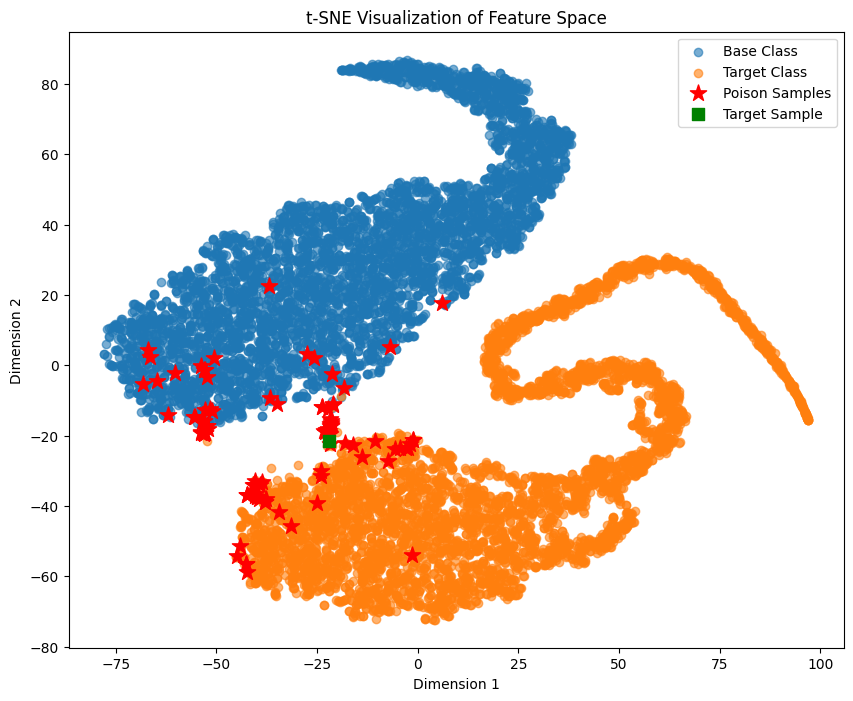

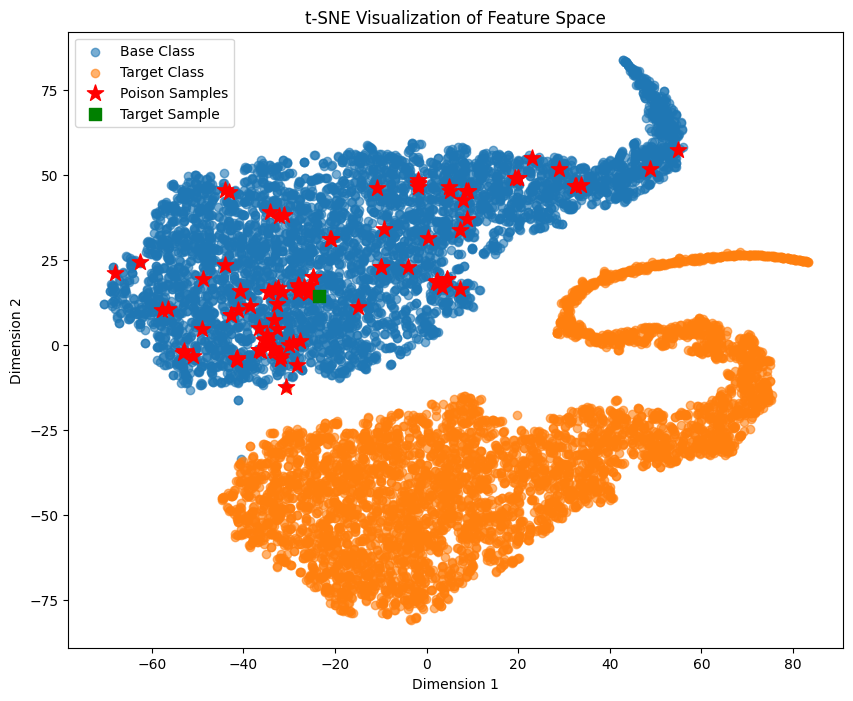

In [38]:
# Visualize the clearn model
watermarks = [watermarkset[-i-1][0] for i in range(watermark_count)]
feature_space_visualizaion(clean_model, trainloader, watermarks, target_image.unsqueeze(0).to(device), base_label, target_label)

# Visualize the attacked model
watermarks = [watermarkset[-i-1][0] for i in range(watermark_count)]
feature_space_visualizaion(wattermarked_model, trainloader, watermarks, target_image.unsqueeze(0).to(device), base_label, target_label)

## Stronger Samples by feeding the Watermarked Samples to Algorithm1

100%|██████████| 100/100 [21:33<00:00, 12.93s/it]


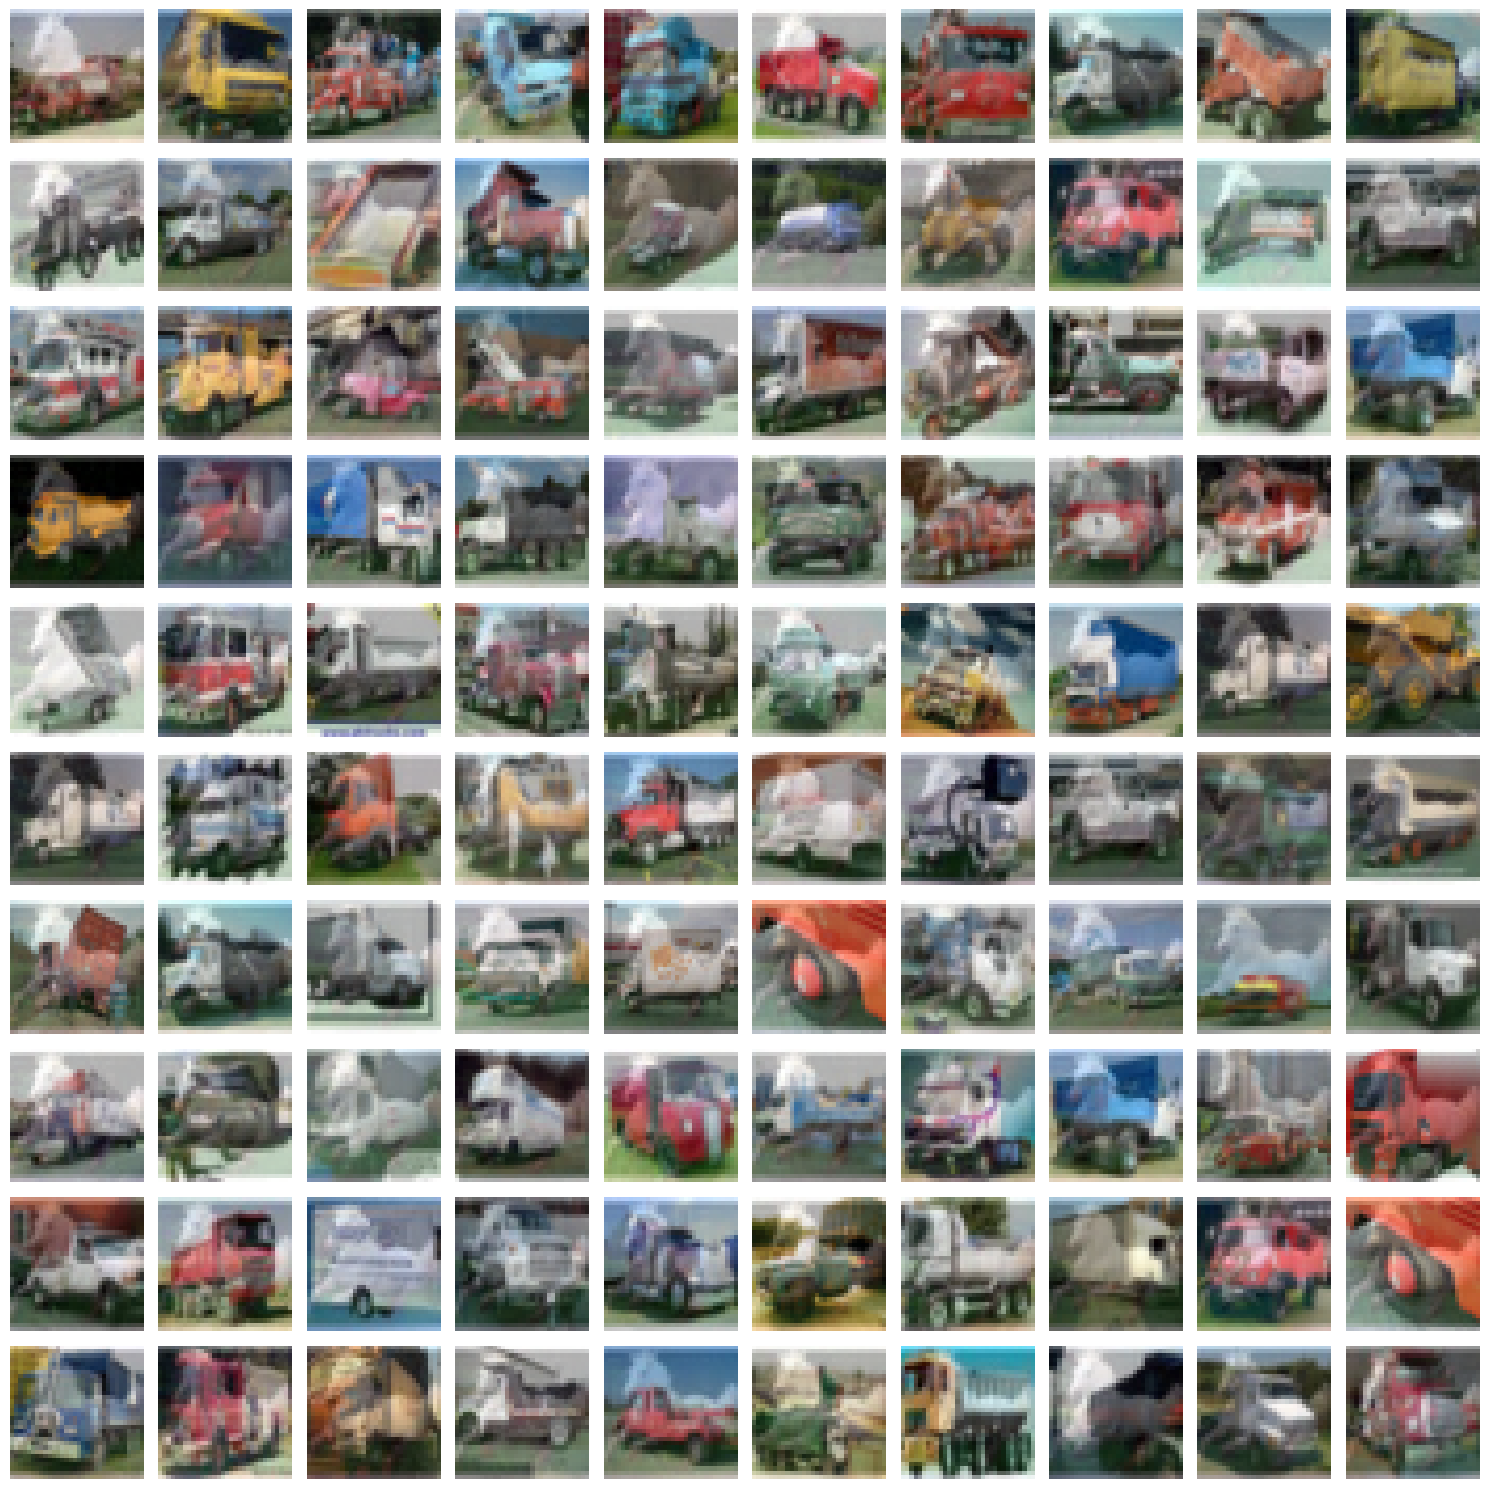

Files already downloaded and verified
The watermark loader consists of 50100 samples.


 10%|█         | 1/10 [00:24<03:39, 24.38s/it]

Epoch 1/10, Loss: 0.0420, Accuracy: 98.5329


 20%|██        | 2/10 [00:48<03:11, 23.94s/it]

Epoch 2/10, Loss: 0.0451, Accuracy: 98.5609


 30%|███       | 3/10 [01:12<02:49, 24.17s/it]

Epoch 3/10, Loss: 0.0305, Accuracy: 99.0000


 40%|████      | 4/10 [01:36<02:25, 24.26s/it]

Epoch 4/10, Loss: 0.0331, Accuracy: 98.9102


 50%|█████     | 5/10 [02:00<02:00, 24.06s/it]

Epoch 5/10, Loss: 0.0308, Accuracy: 99.0419


 60%|██████    | 6/10 [02:25<01:36, 24.24s/it]

Epoch 6/10, Loss: 0.0299, Accuracy: 99.0000


 70%|███████   | 7/10 [02:49<01:12, 24.16s/it]

Epoch 7/10, Loss: 0.0407, Accuracy: 98.6786


 80%|████████  | 8/10 [03:13<00:48, 24.17s/it]

Epoch 8/10, Loss: 0.0272, Accuracy: 99.0200


 90%|█████████ | 9/10 [03:36<00:23, 23.79s/it]

Epoch 9/10, Loss: 0.0413, Accuracy: 98.6407


100%|██████████| 10/10 [04:00<00:00, 24.05s/it]

Epoch 10/10, Loss: 0.0235, Accuracy: 99.2635


Base Sample Label: 9
Target Sample Label: 9
Watermark Samples Label = Base label Percentage: 1.0


In [39]:
import tqdm
watermark_count = 100
base_class = []
poisons = []

for i in range(len(testset.targets)):
  if testset.targets[i] == base_label:
    base_class.append(testset.data[i])

np.random.seed(42)
samples_index = np.random.randint(0, len(base_class), watermark_count)
for i in tqdm.tqdm(samples_index):
    watermarked_sample = poisoning_watermark_generation(target_image_np*255, base_class[i])
    watermarked_sample = (torch.tensor(watermarked_sample)/255).permute(2,0,1)
    posion_sample = poisoning_example_generation(clean_model, target_image.unsqueeze(0).to(device), watermarked_sample.unsqueeze(0).to(device), 0.01)
    posion_sample = np.array(posion_sample.permute(0, 2, 3, 1).detach().cpu()*255, dtype='uint8')
    poisons.append(posion_sample)

visualize_samples([p[0] for p in poisons])
watermarkset = CIFAR10(root='./data', train=True, download=True, transform=transform)


for i in range(len(poisons)):
  watermarkset.targets.append(base_label)
  watermarkset.data = np.append(watermarkset.data, poisons[i] , axis=0)

watermark_loader = torch.utils.data.DataLoader(watermarkset, batch_size=64, shuffle=True, num_workers=2)

print(f'The watermark loader consists of {len(watermark_loader.dataset)} samples.')

wattermarked_model = copy.deepcopy(clean_model)

optimizer = Adam(wattermarked_model.parameters(), lr=0.001)
train_model(wattermarked_model, watermark_loader, optimizer, criterion, 10)

# Evaluate the attack
wattermarked_model.eval()
watermark_pred = 0
with torch.no_grad():
    base_pred = wattermarked_model(base_image.unsqueeze(0).to(device))
    target_pred = wattermarked_model(target_image.unsqueeze(0).to(device))
    for i in range(watermark_count):
        watermark_pred += wattermarked_model(watermarkset[-i-1][0].unsqueeze(0).to(device)).argmax().item() == base_label

print("Base Sample Label:", base_pred.argmax().item())
print("Target Sample Label:", target_pred.argmax().item())
print("Watermark Samples Label = Base label Percentage:", watermark_pred/watermark_count)

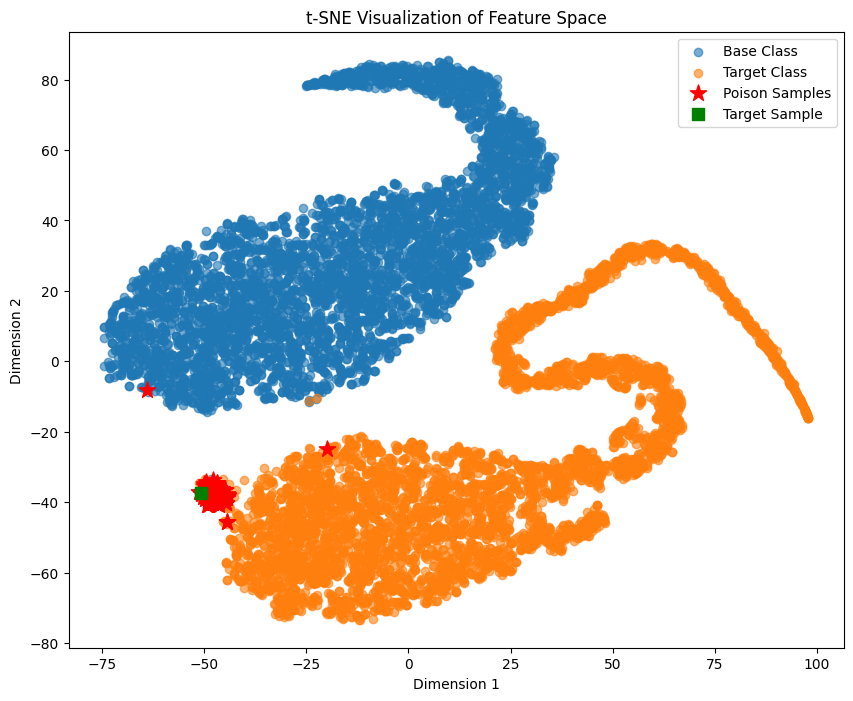

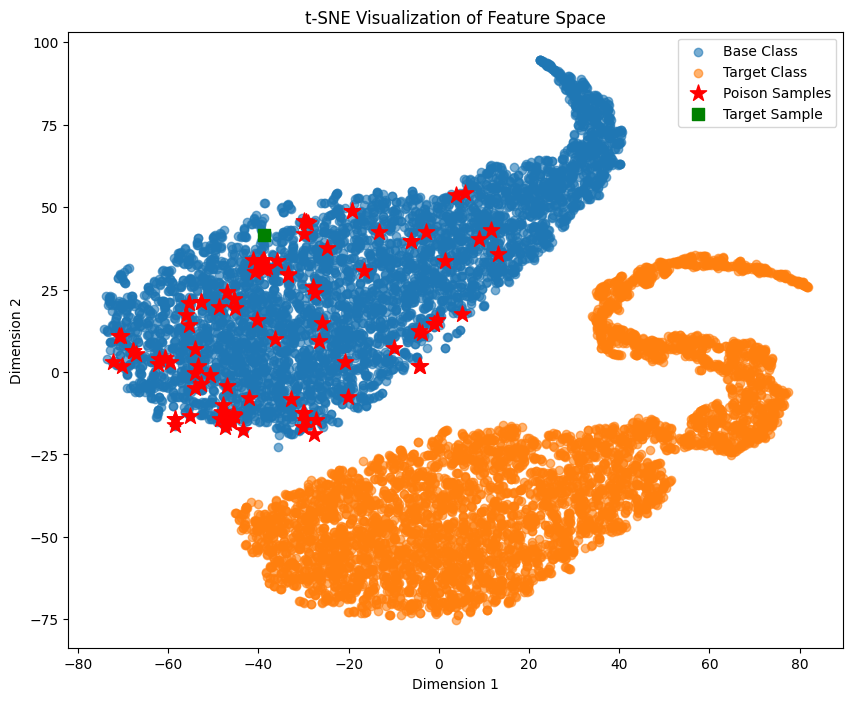

In [40]:
# Visualize the clearn model
watermarks = [watermarkset[-i-1][0] for i in range(watermark_count)]
feature_space_visualizaion(clean_model, trainloader, watermarks, target_image.unsqueeze(0).to(device), base_label, target_label)

# Visualize the attacked model
watermarks = [watermarkset[-i-1][0] for i in range(watermark_count)]
feature_space_visualizaion(wattermarked_model, trainloader, watermarks, target_image.unsqueeze(0).to(device), base_label, target_label)

100%|██████████| 200/200 [43:11<00:00, 12.96s/it]


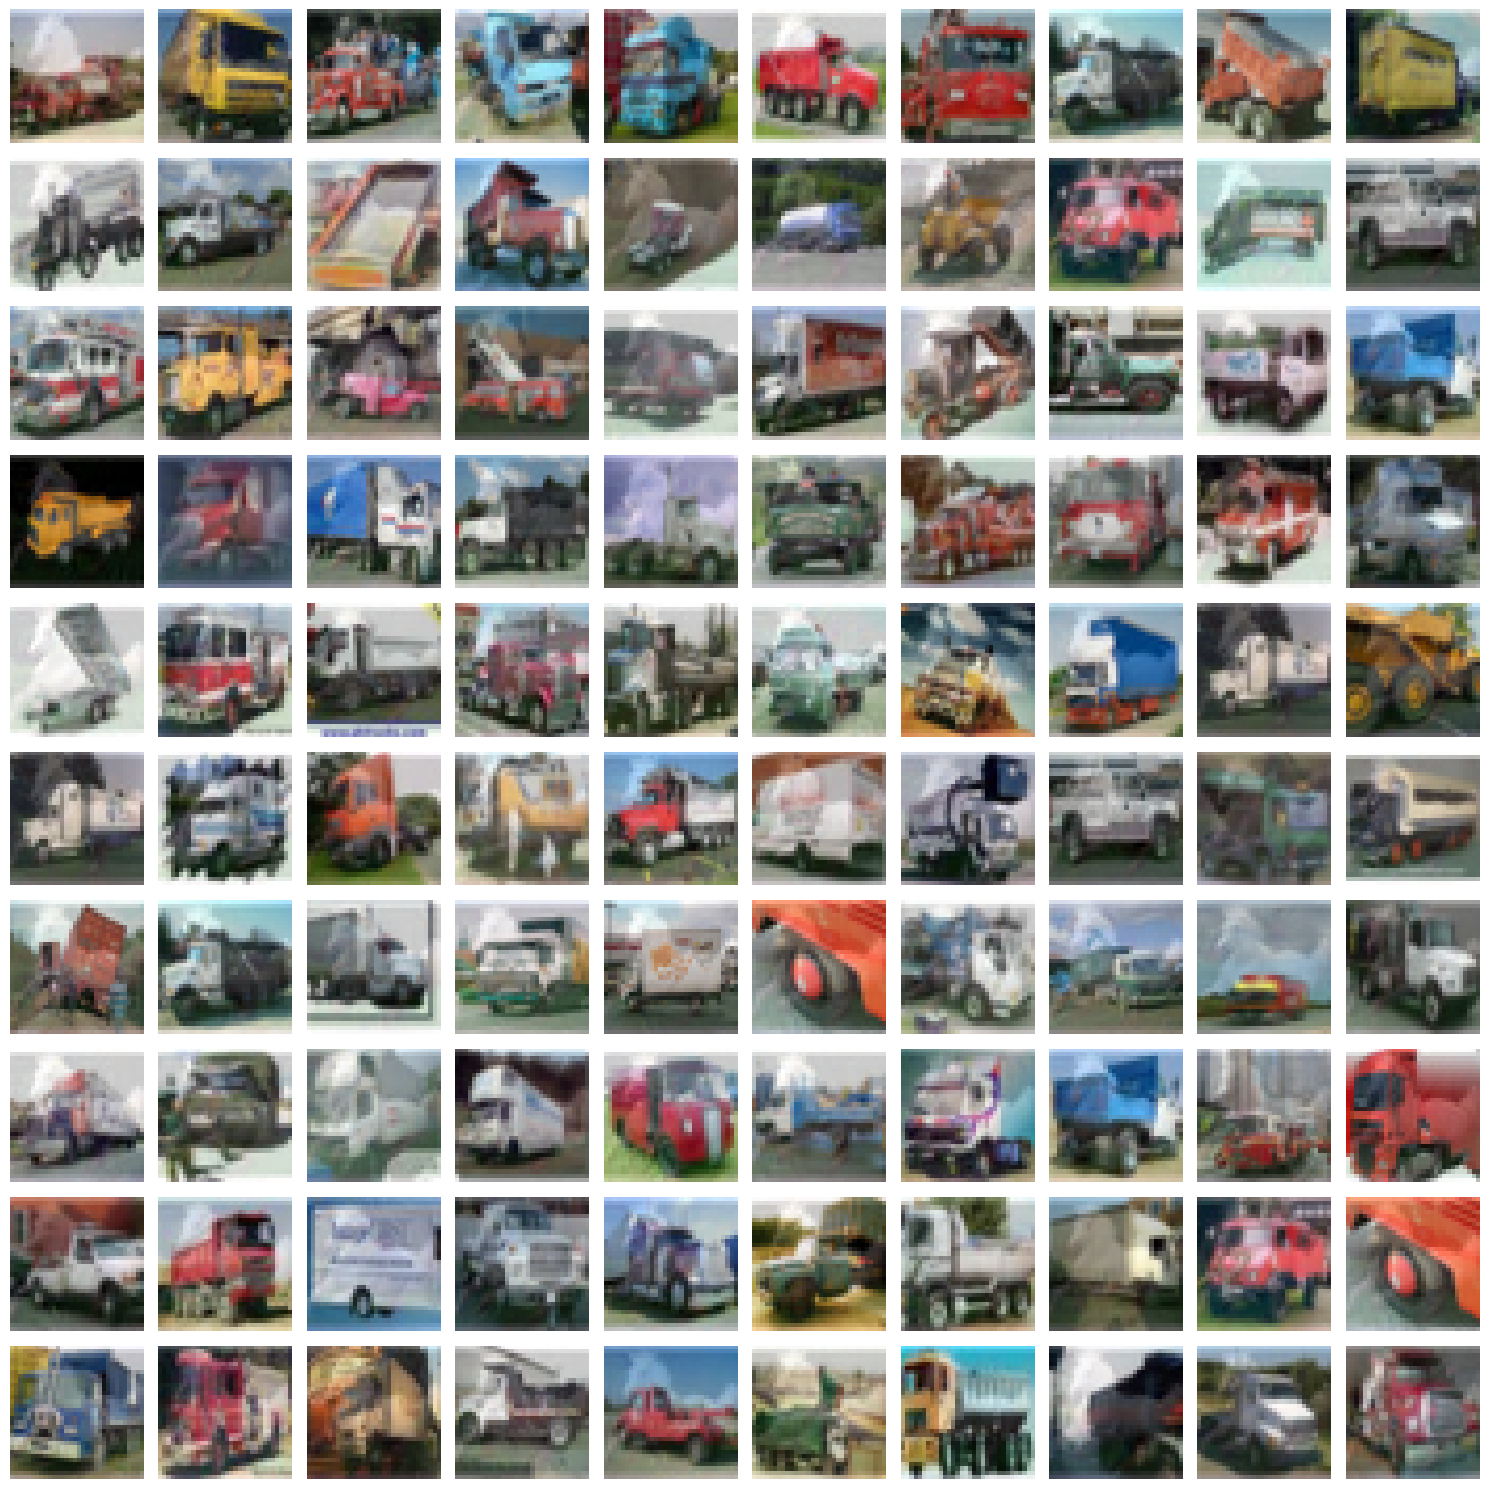

Files already downloaded and verified
The watermark loader consists of 50200 samples.


 10%|█         | 1/10 [00:24<03:38, 24.25s/it]

Epoch 1/10, Loss: 0.0411, Accuracy: 98.6355


 20%|██        | 2/10 [00:48<03:12, 24.03s/it]

Epoch 2/10, Loss: 0.0468, Accuracy: 98.4382


 30%|███       | 3/10 [01:11<02:44, 23.55s/it]

Epoch 3/10, Loss: 0.0291, Accuracy: 99.0319


 40%|████      | 4/10 [01:35<02:22, 23.79s/it]

Epoch 4/10, Loss: 0.0348, Accuracy: 98.8048


 50%|█████     | 5/10 [01:59<01:59, 23.95s/it]

Epoch 5/10, Loss: 0.0540, Accuracy: 98.2849


 60%|██████    | 6/10 [02:22<01:35, 23.78s/it]

Epoch 6/10, Loss: 0.0251, Accuracy: 99.1494


 70%|███████   | 7/10 [02:47<01:11, 23.91s/it]

Epoch 7/10, Loss: 0.0270, Accuracy: 99.0916


 80%|████████  | 8/10 [03:10<00:47, 23.88s/it]

Epoch 8/10, Loss: 0.0305, Accuracy: 98.9781


 90%|█████████ | 9/10 [03:34<00:23, 23.86s/it]

Epoch 9/10, Loss: 0.0435, Accuracy: 98.5976


100%|██████████| 10/10 [03:57<00:00, 23.80s/it]

Epoch 10/10, Loss: 0.0287, Accuracy: 99.1135


Base Sample Label: 9
Target Sample Label: 9
Watermark Samples Label = Base label Percentage: 0.825


In [41]:
watermark_count = 200
base_class = []
poisons = []

for i in range(len(testset.targets)):
  if testset.targets[i] == base_label:
    base_class.append(testset.data[i])

np.random.seed(42)
samples_index = np.random.randint(0, len(base_class), watermark_count)
for i in tqdm.tqdm(samples_index):
    watermarked_sample = poisoning_watermark_generation(target_image_np*255, base_class[i], 0.2)
    watermarked_sample = (torch.tensor(watermarked_sample)/255).permute(2,0,1)
    posion_sample = poisoning_example_generation(clean_model, target_image.unsqueeze(0).to(device), watermarked_sample.unsqueeze(0).to(device), 0.01)
    posion_sample = np.array(posion_sample.permute(0, 2, 3, 1).detach().cpu()*255, dtype='uint8')
    poisons.append(posion_sample)

visualize_samples([p[0] for p in poisons])
watermarkset = CIFAR10(root='./data', train=True, download=True, transform=transform)

for i in range(len(poisons)):
  watermarkset.targets.append(base_label)
  watermarkset.data = np.append(watermarkset.data, poisons[i] , axis=0)

watermark_loader = torch.utils.data.DataLoader(watermarkset, batch_size=64, shuffle=True, num_workers=2)

print(f'The watermark loader consists of {len(watermark_loader.dataset)} samples.')

wattermarked_model = copy.deepcopy(clean_model)

optimizer = Adam(wattermarked_model.parameters(), lr=0.001)
train_model(wattermarked_model, watermark_loader, optimizer, criterion, 10)

# Evaluate the attack
wattermarked_model.eval()
watermark_pred = 0
with torch.no_grad():
    base_pred = wattermarked_model(base_image.unsqueeze(0).to(device))
    target_pred = wattermarked_model(target_image.unsqueeze(0).to(device))
    for i in range(watermark_count):
        watermark_pred += wattermarked_model(watermarkset[-i-1][0].unsqueeze(0).to(device)).argmax().item() == base_label

print("Base Sample Label:", base_pred.argmax().item())
print("Target Sample Label:", target_pred.argmax().item())
print("Watermark Samples Label = Base label Percentage:", watermark_pred/watermark_count)

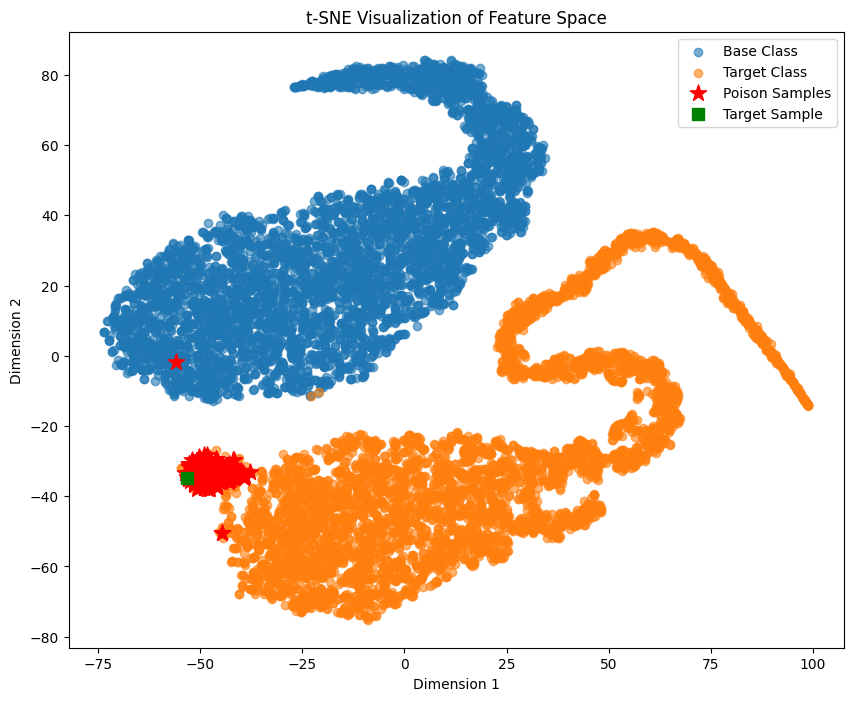

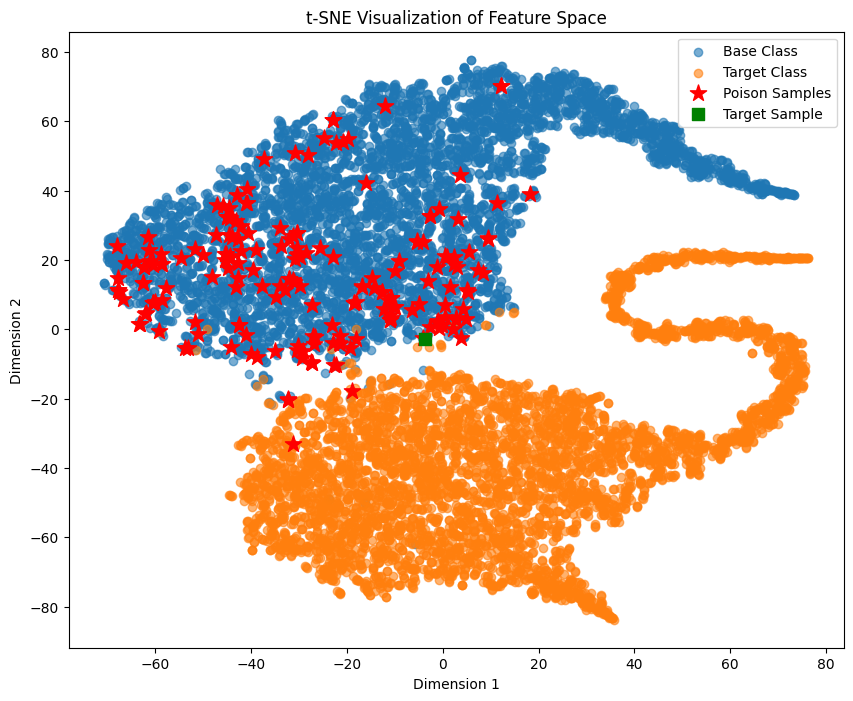

In [42]:
# Visualize the clearn model
watermarks = [watermarkset[-i-1][0] for i in range(watermark_count)]
feature_space_visualizaion(clean_model, trainloader, watermarks, target_image.unsqueeze(0).to(device), base_label, target_label)

# Visualize the attacked model
watermarks = [watermarkset[-i-1][0] for i in range(watermark_count)]
feature_space_visualizaion(wattermarked_model, trainloader, watermarks, target_image.unsqueeze(0).to(device), base_label, target_label)

این بخشای اضافه رو فارسی توضیح میدم: فاین تیون کردن لایه آخر برای 100 تا واترمارک دردی دوا نکرد.
ولی یه چیزی که کلا تی‌اس‌ان‌ای نشون میده اینه که واتر مارک خالی بدرد نمیخورده چون تو لایه فیچر نزدیک نمیوفتن. ولی اگه تعداد سمپلا رو زیاد کنیم شانس نزدیک شدن بیشتر میشه که خب با 500 تا نتیجه داد. اگرم گاما رو خیلی زیاد کنیم (0.5) موفقیت آمیزه اما خب چشمی خیلی واضحه سمپلاش. یک نتیجه اش هم تو تی‌اس‌ان‌ای جالبه و نشون میده خیلی سمپلا نزدیک مرز دوتا کلاس میوفتن و نصف نصف هم توی بیس و تارگت قرار میگیرن. اگرم خروجی واتر مارک رو بدیم به الگوریتم اولی که توی فیچر نزدیکشون کنه هم گاما و تعداد کمتری می خواد هم ظاهر سمپلا بهتره. هم با گاما 0.3 و 100 سمپل نتیجه داد هم با گاما 0.2 و 200 سمپل